In [1]:
!pip install transformers torch faiss-gpu numpy pandas scikit-learn gensim rouge-score bert-score evaluate rouge


  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=8eae6004eb058263d34302c886d27d247fc684dca3cf6075081dbbb14cc37e7e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import pandas as pd

#Extracting original diseases so that the results from the models can be verified for proper inference
#Then it will be used as the ground truth for calculating the evaluation metrices
test_dataset = pd.read_csv('/kaggle/input/data-preparation-symptom-disease-classification/test_primary.csv')
original_diseases = test_dataset['disease'].tolist()

In [3]:
def validate_test_dataset(new_diseases):
    return new_diseases == original_diseases

In [4]:
def is_within_original_labels(predictions):
    # Check if any element in predictions is not in actual_problems
    actual_problems_set = set(original_diseases)
    not_in_actual_problems = [pred for pred in predictions if pred not in actual_problems_set]

    if not_in_actual_problems:
        print("Elements in predictions not found in original_diseases:", not_in_actual_problems)
        return False
    else:
        print("All elements in predictions are found in original_diseases.")
        return True
    

In [5]:
def validate_outputs(actual_problems,predictions):
    return validate_test_dataset(actual_problems) and is_within_original_labels(predictions)

In [6]:
# Creating Index for Post-Processing of outputs using faiss-gpu

import torch
from transformers import AutoTokenizer, AutoModel
import faiss
import numpy as np
import os
import pandas as pd

index_type = "faiss-IndexFlatL2"

tokenizer = AutoTokenizer.from_pretrained('medicalai/ClinicalBERT')
model = AutoModel.from_pretrained('medicalai/ClinicalBERT')


# Function to get BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token
    return embeddings.numpy()

known_labels = original_diseases[:]
# Generate embeddings for known labels
known_label_embeddings = get_bert_embeddings(known_labels)

# Ensure the array is C-contiguous
known_label_embeddings = np.ascontiguousarray(known_label_embeddings)

# Build FAISS index
d = known_label_embeddings.shape[1]  # Dimension of the embeddings

# Change Indexing Type Here
index = faiss.IndexFlatL2(d)
index.add(known_label_embeddings)

# Directory to save the FAISS index
index_directory = f'/kaggle/working/evaluation/{index_type}/indexes'
os.makedirs(index_directory, exist_ok=True)

# File path for the FAISS index
index_file_path = os.path.join(index_directory, f'{index_type}_index.bin')

# Save the FAISS index to a file
faiss.write_index(index, index_file_path)
print(f"FAISS index saved to {index_file_path}")

# Load the FAISS index from the file
loaded_index = faiss.read_index(index_file_path)
print(f"FAISS index loaded from {index_file_path}")

# Function to find most similar known label using FAISS
def find_most_similar_label(prediction, index, known_labels):
    pred_embedding = get_bert_embeddings([prediction])
    D, I = index.search(pred_embedding, 1)  # Search for the nearest neighbor
    most_similar_idx = I[0][0]
    return known_labels[most_similar_idx]

# Function to fix predictions
def fix_predictions(predictions, index, known_labels):
    fixed_predictions = []
    for pred in predictions:
        if pred in known_labels:
            fixed_predictions.append(pred)
        else:
            most_similar_label = find_most_similar_label(pred, index, known_labels)
            fixed_predictions.append(most_similar_label)
    return fixed_predictions

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


FAISS index saved to /kaggle/working/evaluation/faiss-IndexFlatL2/indexes/faiss-IndexFlatL2_index.bin
FAISS index loaded from /kaggle/working/evaluation/faiss-IndexFlatL2/indexes/faiss-IndexFlatL2_index.bin


In [7]:
#dictionary to store evaluation metrics for all models
llms_data = {}

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from rouge import Rouge
from bert_score import score as bert_score
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns  # Add this line for seaborn

def t2t_evaluate(model_name, model_type, csv_file_path):
    
    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Extract actual problems and predictions as lists
    actual_problems = df['output'].tolist()
    predictions = df['prediction'].tolist()
    
    def custom_strip(s, chars):
        chars_set = set(chars)  # Convert list of chars to a set for faster membership checking

        # Strip characters from the start
        while s and s[0] in chars_set:
            s = s[1:]

        # Strip characters from the end
        while s and s[-1] in chars_set:
            s = s[:-1]

        return s

    # Function to segregate and extract health problems
    def extract_health_problems(predictions):
        extracted_problems = []
        followed_instruction_count = 0
        flouted_instruction_count = 0

        for pred in predictions:
            health_problem = pred
            if pred.startswith("Identified Health Problem : "):
                # Followed instruction
                health_problem = pred[len("Identified Health Problem : "):].strip()
                if '\n' not in health_problem or '\n' in health_problem and all(char in [' ', '\n'] for char in health_problem.split('\n')[1:]):
                    # Count as followed instruction
                    followed_instruction_count += 1
                else:
                    # Count as flouted instruction
                    flouted_instruction_count += 1
            elif pred.startswith("Identified Health Problem: "):
                # Followed instruction
                health_problem = pred[len("Identified Health Problem: "):].strip()
                if '\n' not in health_problem or '\n' in health_problem and all(char in [' ', '\n'] for char in health_problem.split('\n')[1:]):
                    # Count as followed instruction
                    followed_instruction_count += 1
                else:
                    # Count as flouted instruction
                    flouted_instruction_count += 1
            else:
                # Flouted instruction
                flouted_instruction_count += 1
            health_problem = health_problem.split('\n')[0].split('#')[0].split('.')[0]

            extracted_problems.append(health_problem)

        return extracted_problems, followed_instruction_count, flouted_instruction_count
    actual_problems, _, _ = extract_health_problems(actual_problems)
    predictions, followed, flouted = extract_health_problems(predictions)
    
    # post-processing
    predictions = fix_predictions(predictions, index, actual_problems)
    
    
    
    
    if (validate_outputs(actual_problems,predictions) == False):
        return "failure"
    
    # Suppress warnings for calculate_rouge_score and calculate_bert_score functions
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        
        def calculate_rouge_score(generated_texts, reference_texts):
            rouge = evaluate.load('rouge')
            results = rouge.compute(predictions=generated_texts, references=reference_texts)
            #rouge_scores = rouge.get_scores(generated_texts, reference_texts)
            #return rouge_scores
            return results

        def calculate_bert_score(generated_texts, reference_texts):
            P, R, F1 = bert_score(generated_texts, reference_texts, lang='en', verbose=False)
            return {
                'precision': P.tolist(),
                'recall': R.tolist(),
                'f1_score': F1.tolist()
            }
    
    # Define a function to calculate classification metrics
    def calculate_classification_metrics(actual, predicted):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            accuracy = accuracy_score(actual, predicted)
            precision = precision_score(actual, predicted, average='weighted', zero_division=0)
            recall = recall_score(actual, predicted, average='weighted', zero_division=0)
            f1 = f1_score(actual, predicted, average='weighted', zero_division=0)
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    # Calculate classification metrics
    classification_metrics = calculate_classification_metrics(actual_problems, predictions)


    # Text-to-Text Metrics
    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_score(predictions, actual_problems)

    # Calculate BERT scores
    bert_scores = calculate_bert_score(predictions, actual_problems)
    


    # Calculate average scores
#     avg_rouge_precision_1 = np.mean([score['rouge-1']['p'] for score in rouge_scores])
#     avg_rouge_recall_1 = np.mean([score['rouge-1']['r'] for score in rouge_scores])
#     avg_rouge_f1_1 = np.mean([score['rouge-1']['f'] for score in rouge_scores])

#     avg_rouge_precision_2 = np.mean([score['rouge-2']['p'] for score in rouge_scores])
#     avg_rouge_recall_2 = np.mean([score['rouge-2']['r'] for score in rouge_scores])
#     avg_rouge_f1_2 = np.mean([score['rouge-2']['f'] for score in rouge_scores])

#     avg_rouge_precision_l = np.mean([score['rouge-l']['p'] for score in rouge_scores])
#     avg_rouge_recall_l = np.mean([score['rouge-l']['r'] for score in rouge_scores])
#     avg_rouge_f1_l = np.mean([score['rouge-l']['f'] for score in rouge_scores])

    avg_bert_precision = np.mean(bert_scores['precision'])
    avg_bert_recall = np.mean(bert_scores['recall'])
    avg_bert_f1 = np.mean(bert_scores['f1_score'])
    
    
    print("\nModel Name : ", model_name)
    print("Model Type : ", model_type)
    print("")
    val = followed*1.0/(followed + flouted)
    print("Valid Instruction Following Predictions Score : ", f'{val:.3f}')
    print("")
    
    print("Classification Metrics:\n")
    print(f"Accuracy: {classification_metrics['accuracy']:.3f}")
    print(f"Precision: {classification_metrics['precision']:.3f}")
    print(f"Recall: {classification_metrics['recall']:.3f}")
    print(f"F1 Score: {classification_metrics['f1_score']:.3f}")
    print("")
    
    
    print("Text to Text Metrics:\n")
    print("ROUGE Scores:")
    print(f"ROUGE-1: {rouge_scores['rouge1']:.3f}")
    print(f"ROUGE-2: {rouge_scores['rouge2']:.3f}")
    print(f"ROUGE-L: {rouge_scores['rougeL']:.3f}")
    print(f"ROUGE-Lsum: {rouge_scores['rougeLsum']:.3f}")
    print("")
    print(f"Average BERT Precision: {avg_bert_precision:.3f}")
    print(f"Average BERT Recall: {avg_bert_recall:.3f}")
    print(f"Average BERT F1 Score: {avg_bert_f1:.3f}")
    
    print("\n\n-------------------------------------------------------------------------------\n")
    
    print("\nmodel-name : ", model_name)
    print("model-type : ",model_type)
    print("")
    val = followed*1.0/(followed + flouted)
    print("valid-instruction-rating : ", f'{val:.3f}')
    print("")
    
    print("classification-metrics:\n")
    print(f"accuracy: {classification_metrics['accuracy']:.3f}")
    print(f"precision: {classification_metrics['precision']:.3f}")
    print(f"recall: {classification_metrics['recall']:.3f}")
    print(f"f1-score: {classification_metrics['f1_score']:.3f}")
    print("")
    
    
    print("text-to-text-metrics:\n")
    print("rouge-scores:")
    print(f"rouge-1: {rouge_scores['rouge1']:.3f}")
    print(f"rouge-2: {rouge_scores['rouge2']:.3f}")
    print(f"rouge-L: {rouge_scores['rougeL']:.3f}")
    print(f"rouge-lsum: {rouge_scores['rougeLsum']:.3f}")
    print("")
    print(f"bert-precision: {avg_bert_precision:.3f}")
    print(f"bert-recall: {avg_bert_recall:.3f}")
    print(f"bert-f1-score: {avg_bert_f1:.3f}")
    
# Initialize the model_name key if it doesn't exist
    if model_name not in llms_data:
        llms_data[model_name] = {}

    # Update the llms_data dictionary with rounded values directly
    llms_data[model_name].update({
        model_type: {
            "valid-instruction-rating": round(val, 3),
            "classification-metrics": {
                "accuracy": round(classification_metrics["accuracy"], 3),
                "precision": round(classification_metrics["precision"], 3),
                "recall": round(classification_metrics["recall"], 3),
                "f1-score": round(classification_metrics["f1_score"], 3)
            },
            "text-to-text-metrics": {
                "rouge-scores": {
                    "rouge-1": round(rouge_scores["rouge1"], 3),
                    "rouge-2": round(rouge_scores["rouge2"], 3),
                    "rouge-L": round(rouge_scores["rougeL"], 3),
                    "rouge-lsum": round(rouge_scores["rougeLsum"], 3)
                },
                "bert-precision": round(avg_bert_precision, 3),
                "bert-recall": round(avg_bert_recall, 3),
                "bert-f1-score": round(avg_bert_f1, 3)
            }
        }
    })

    # Print the updated dictionary
    print("\nUpdated llms_data dictionary:")
    #---------------------------------------------------------------------------------------
    
    #Confusion-Matrix
    # Determine unique labels present in actual_problems and predictions
    unique_labels = np.unique(actual_problems + predictions)

    # Map labels to integer indices
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    mapped_actual_problems = [label_to_index[label] for label in actual_problems]
    mapped_predictions = [label_to_index[label] for label in predictions]

    # Plot confusion matrix
    confusion_mtx = confusion_matrix(mapped_actual_problems, mapped_predictions, labels=np.arange(len(unique_labels)))

    # Plotting the confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(confusion_mtx, annot=False, fmt='d', cmap='Blues')
    plt.xlabel('Original Health Problems')
    plt.ylabel('Predicted Health Problems ')
    plt.title(f'Confusion Matrix for {model_name} ({model_type}) with Post-Processing using {index_type}')
    
    #Saving result .jpg
    image_directory = f'/kaggle/working/evaluation/{index_type}/confusion_matrix/{model_name}'
    os.makedirs(image_directory, exist_ok=True)

    # File path for the FAISS index
    image_file_path = os.path.join(image_directory, f'confusion_matrix_{index_type}_{model_name}_{model_type}.jpg')
    
    # Save confusion matrix as high-resolution JPEG
    plt.savefig(image_file_path, dpi=300)
    
    plt.show()
    
    return "success"


2024-06-15 12:34:12.614277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 12:34:12.614373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 12:34:12.857861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All elements in predictions are found in original_diseases.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  qwen2-7b-instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.997

Classification Metrics:

Accuracy: 0.252
Precision: 0.408
Recall: 0.252
F1 Score: 0.248

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.273
ROUGE-2: 0.123
ROUGE-L: 0.272
ROUGE-Lsum: 0.273

Average BERT Precision: 0.854
Average BERT Recall: 0.873
Average BERT F1 Score: 0.863


-------------------------------------------------------------------------------


model-name :  qwen2-7b-instruct
model-type :  pretrained

valid-instruction-rating :  0.997

classification-metrics:

accuracy: 0.252
precision: 0.408
recall: 0.252
f1-score: 0.248

text-to-text-metrics:

rouge-scores:
rouge-1: 0.273
rouge-2: 0.123
rouge-L: 0.272
rouge-lsum: 0.273

bert-precision: 0.854
bert-recall: 0.873
bert-f1-score: 0.863

Updated llms_data dictionary:


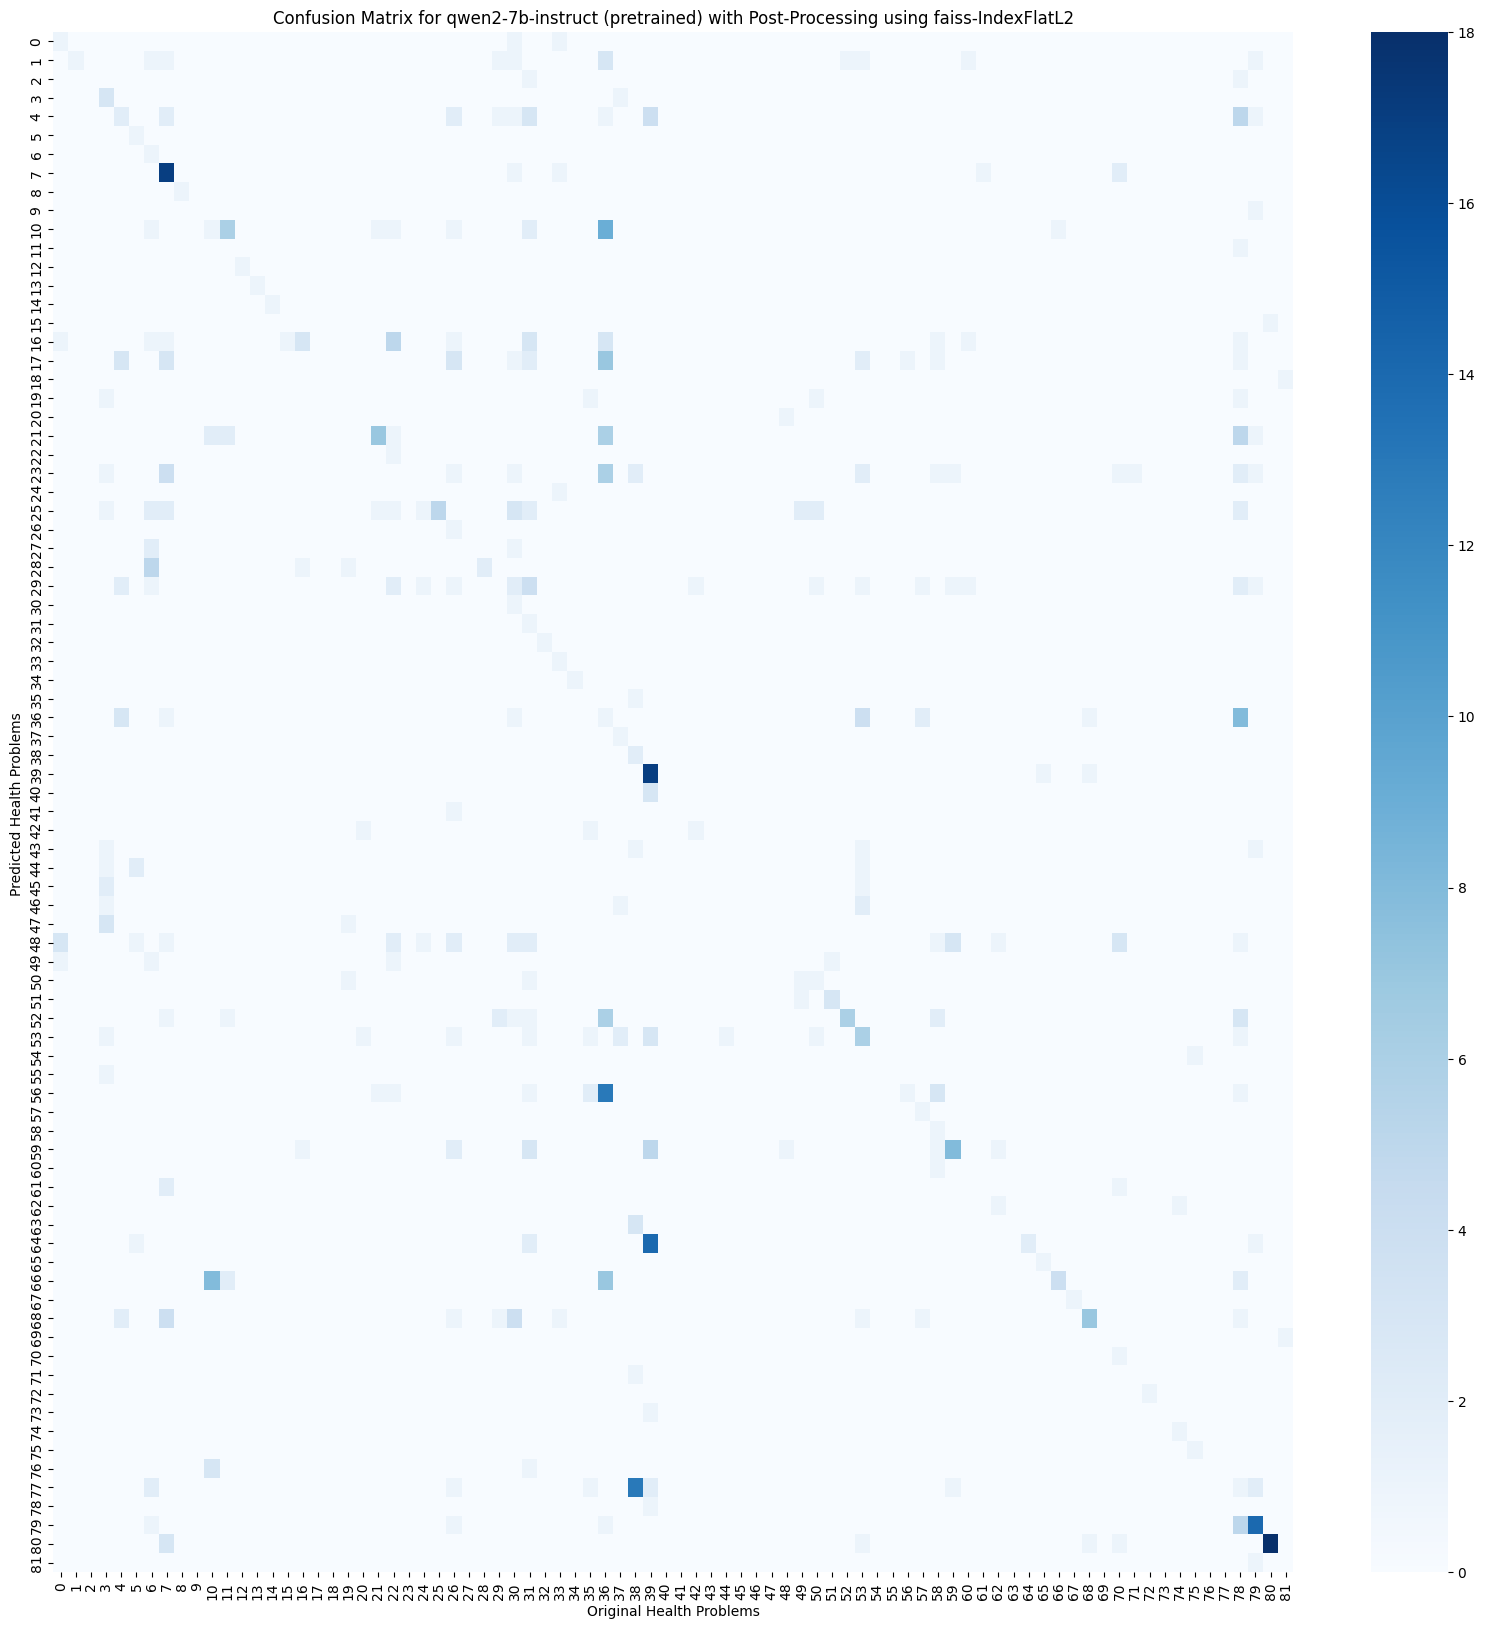

'success'

In [9]:
t2t_evaluate(model_name='Qwen2-7B-Instruct'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-qwen2-7b-instruct-pretrain/results/predictions-Qwen2-7B-Instruct-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  qwen2-7b-instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.998

Classification Metrics:

Accuracy: 0.843
Precision: 0.916
Recall: 0.843
F1 Score: 0.848

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.845
ROUGE-2: 0.421
ROUGE-L: 0.843
ROUGE-Lsum: 0.843

Average BERT Precision: 0.977
Average BERT Recall: 0.972
Average BERT F1 Score: 0.974


-------------------------------------------------------------------------------


model-name :  qwen2-7b-instruct
model-type :  fine-tuned

valid-instruction-rating :  0.998

classification-metrics:

accuracy: 0.843
precision: 0.916
recall: 0.843
f1-score: 0.848

text-to-text-metrics:

rouge-scores:
rouge-1: 0.845
rouge-2: 0.421
rouge-L: 0.843
rouge-lsum: 0.843

bert-precision: 0.977
bert-recall: 0.972
bert-f1-score: 0.974

Updated llms_data dictionary:


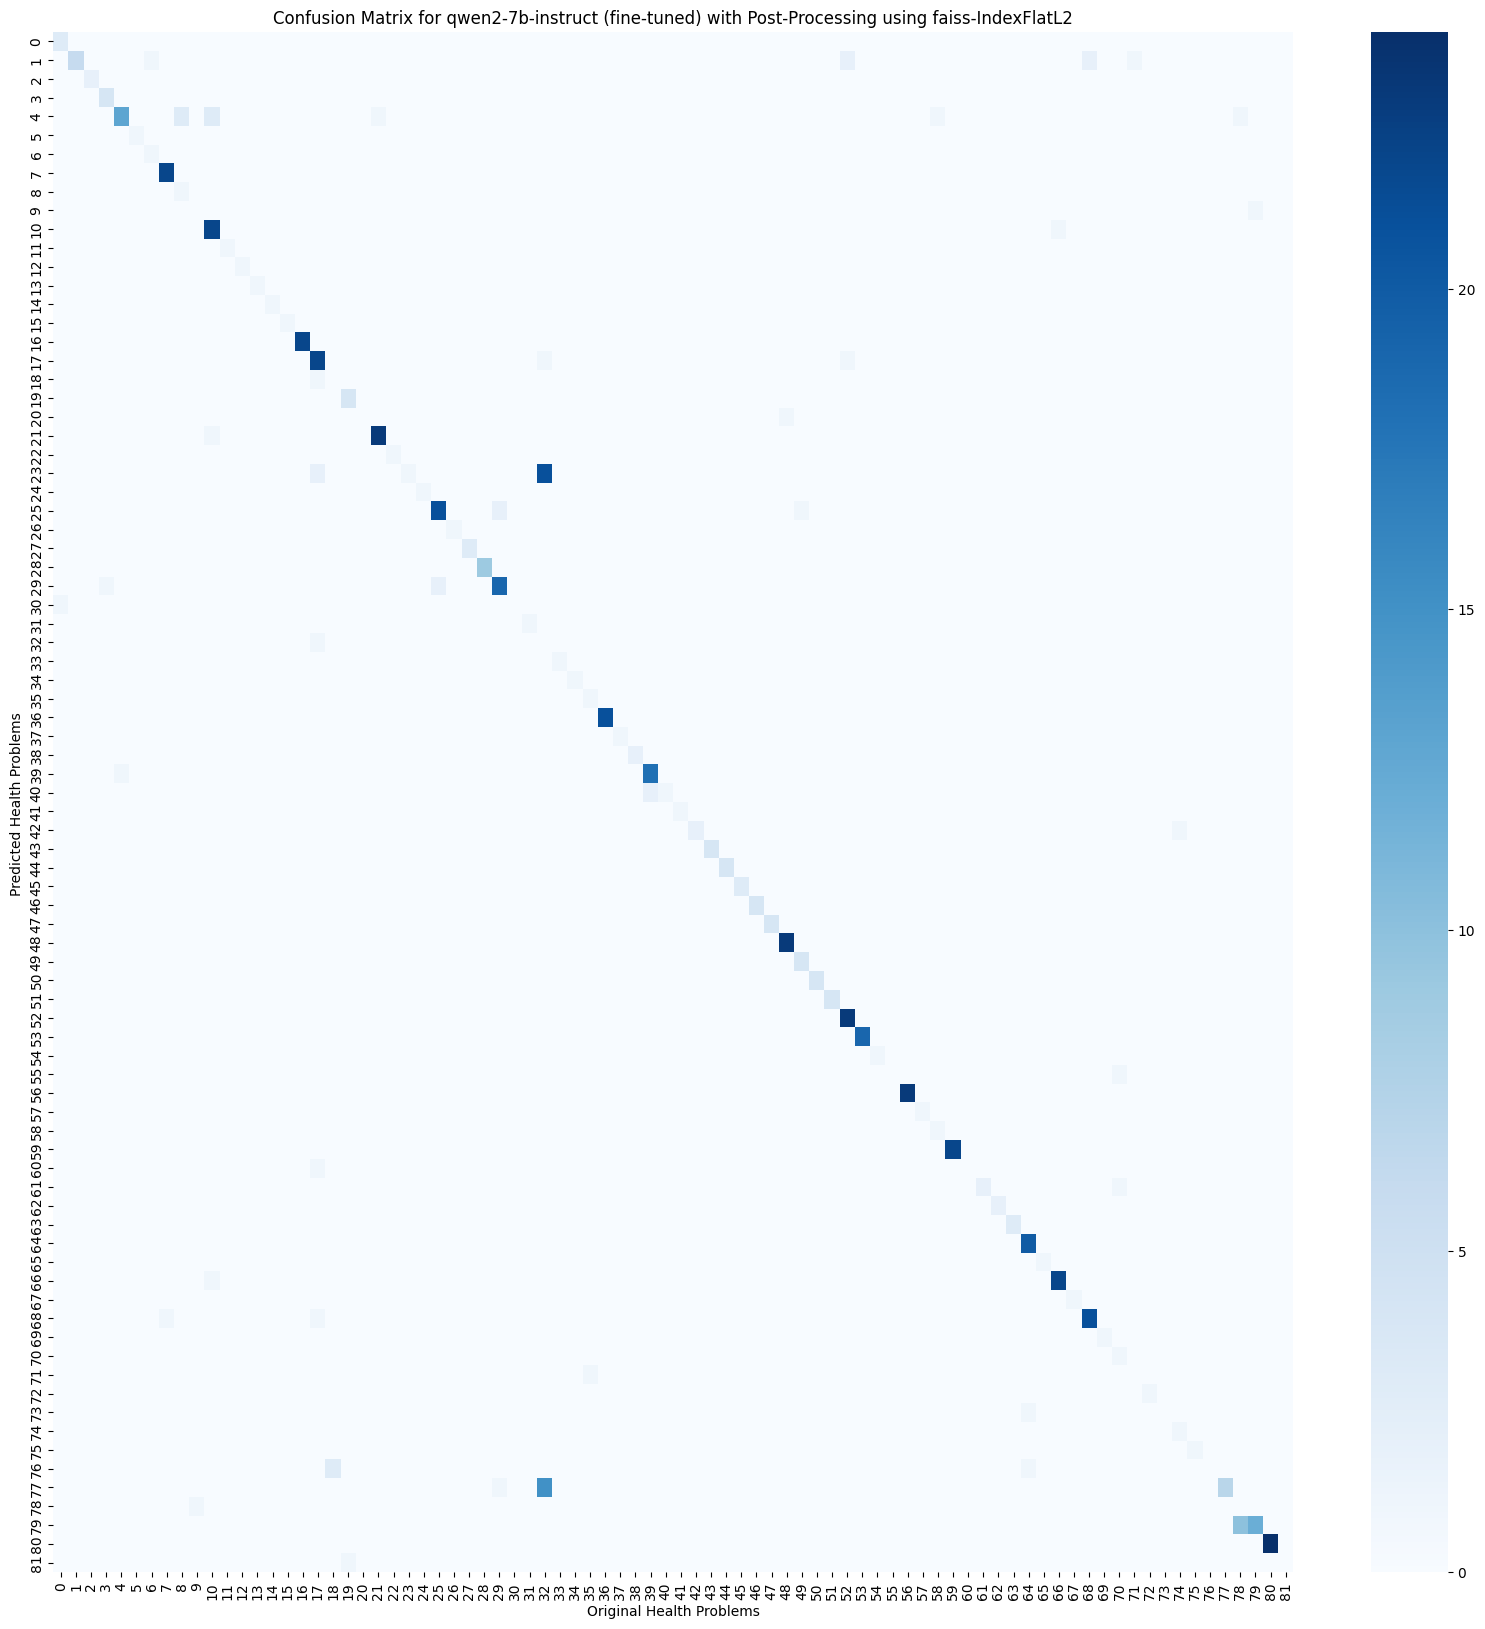

'success'

In [10]:
t2t_evaluate(model_name='Qwen2-7B-Instruct'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-qwen2-7b-instruct-fine-tune/results/predictions-Qwen2-7B-Instruct-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  gemma-7b-instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.134

Classification Metrics:

Accuracy: 0.191
Precision: 0.254
Recall: 0.191
F1 Score: 0.190

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.202
ROUGE-2: 0.086
ROUGE-L: 0.202
ROUGE-Lsum: 0.202

Average BERT Precision: 0.851
Average BERT Recall: 0.854
Average BERT F1 Score: 0.851


-------------------------------------------------------------------------------


model-name :  gemma-7b-instruct
model-type :  pretrained

valid-instruction-rating :  0.134

classification-metrics:

accuracy: 0.191
precision: 0.254
recall: 0.191
f1-score: 0.190

text-to-text-metrics:

rouge-scores:
rouge-1: 0.202
rouge-2: 0.086
rouge-L: 0.202
rouge-lsum: 0.202

bert-precision: 0.851
bert-recall: 0.854
bert-f1-score: 0.851

Updated llms_data dictionary:


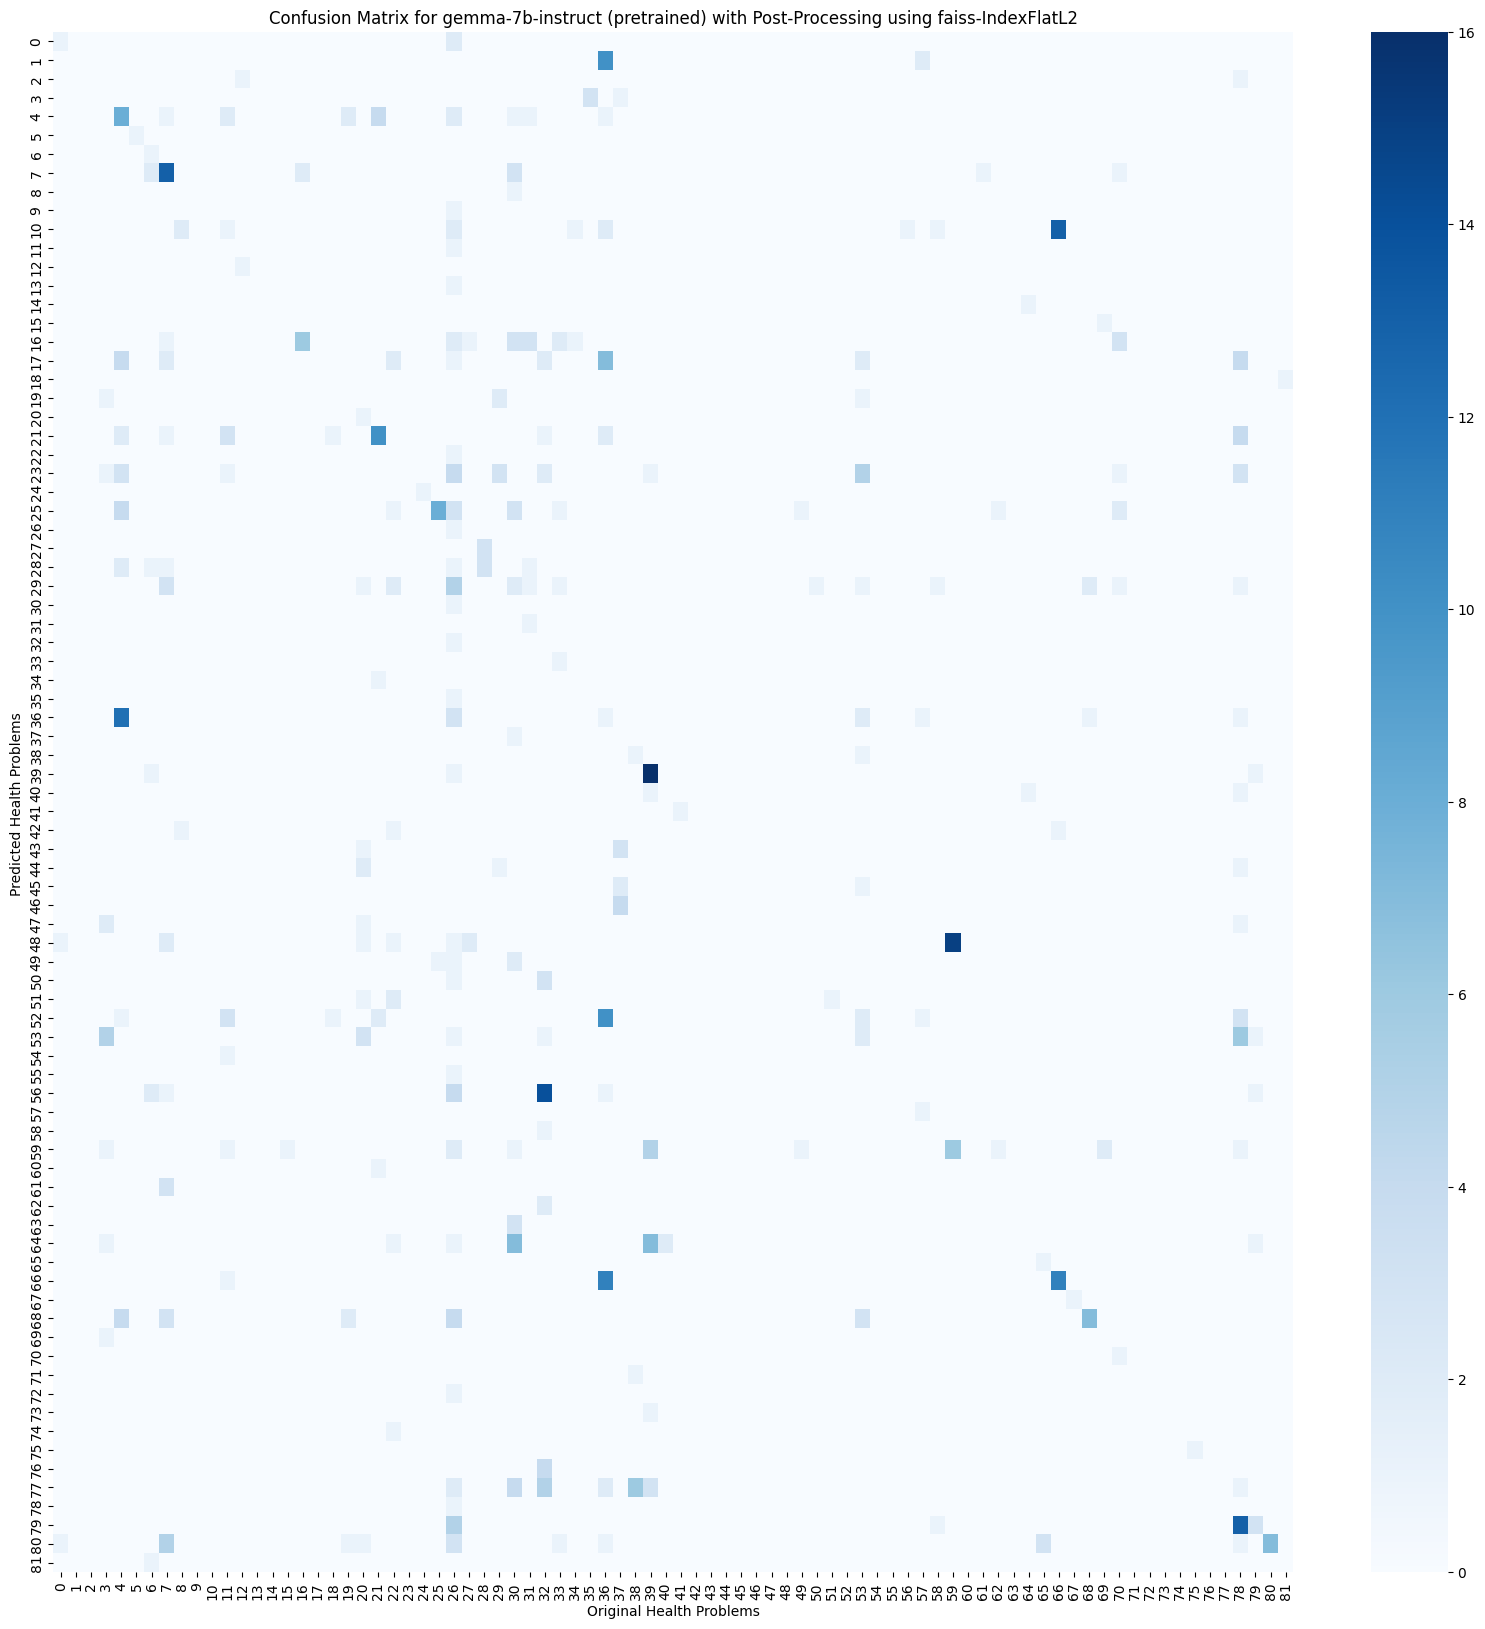

'success'

In [11]:
t2t_evaluate(model_name='Gemma-7B-Instruct'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-gemma-7b-it-pretrain/results/predictions-gemma-7b-it-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  gemma-7b-instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.974

Classification Metrics:

Accuracy: 0.657
Precision: 0.725
Recall: 0.657
F1 Score: 0.659

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.679
ROUGE-2: 0.319
ROUGE-L: 0.676
ROUGE-Lsum: 0.677

Average BERT Precision: 0.935
Average BERT Recall: 0.944
Average BERT F1 Score: 0.939


-------------------------------------------------------------------------------


model-name :  gemma-7b-instruct
model-type :  fine-tuned

valid-instruction-rating :  0.974

classification-metrics:

accuracy: 0.657
precision: 0.725
recall: 0.657
f1-score: 0.659

text-to-text-metrics:

rouge-scores:
rouge-1: 0.679
rouge-2: 0.319
rouge-L: 0.676
rouge-lsum: 0.677

bert-precision: 0.935
bert-recall: 0.944
bert-f1-score: 0.939

Updated llms_data dictionary:


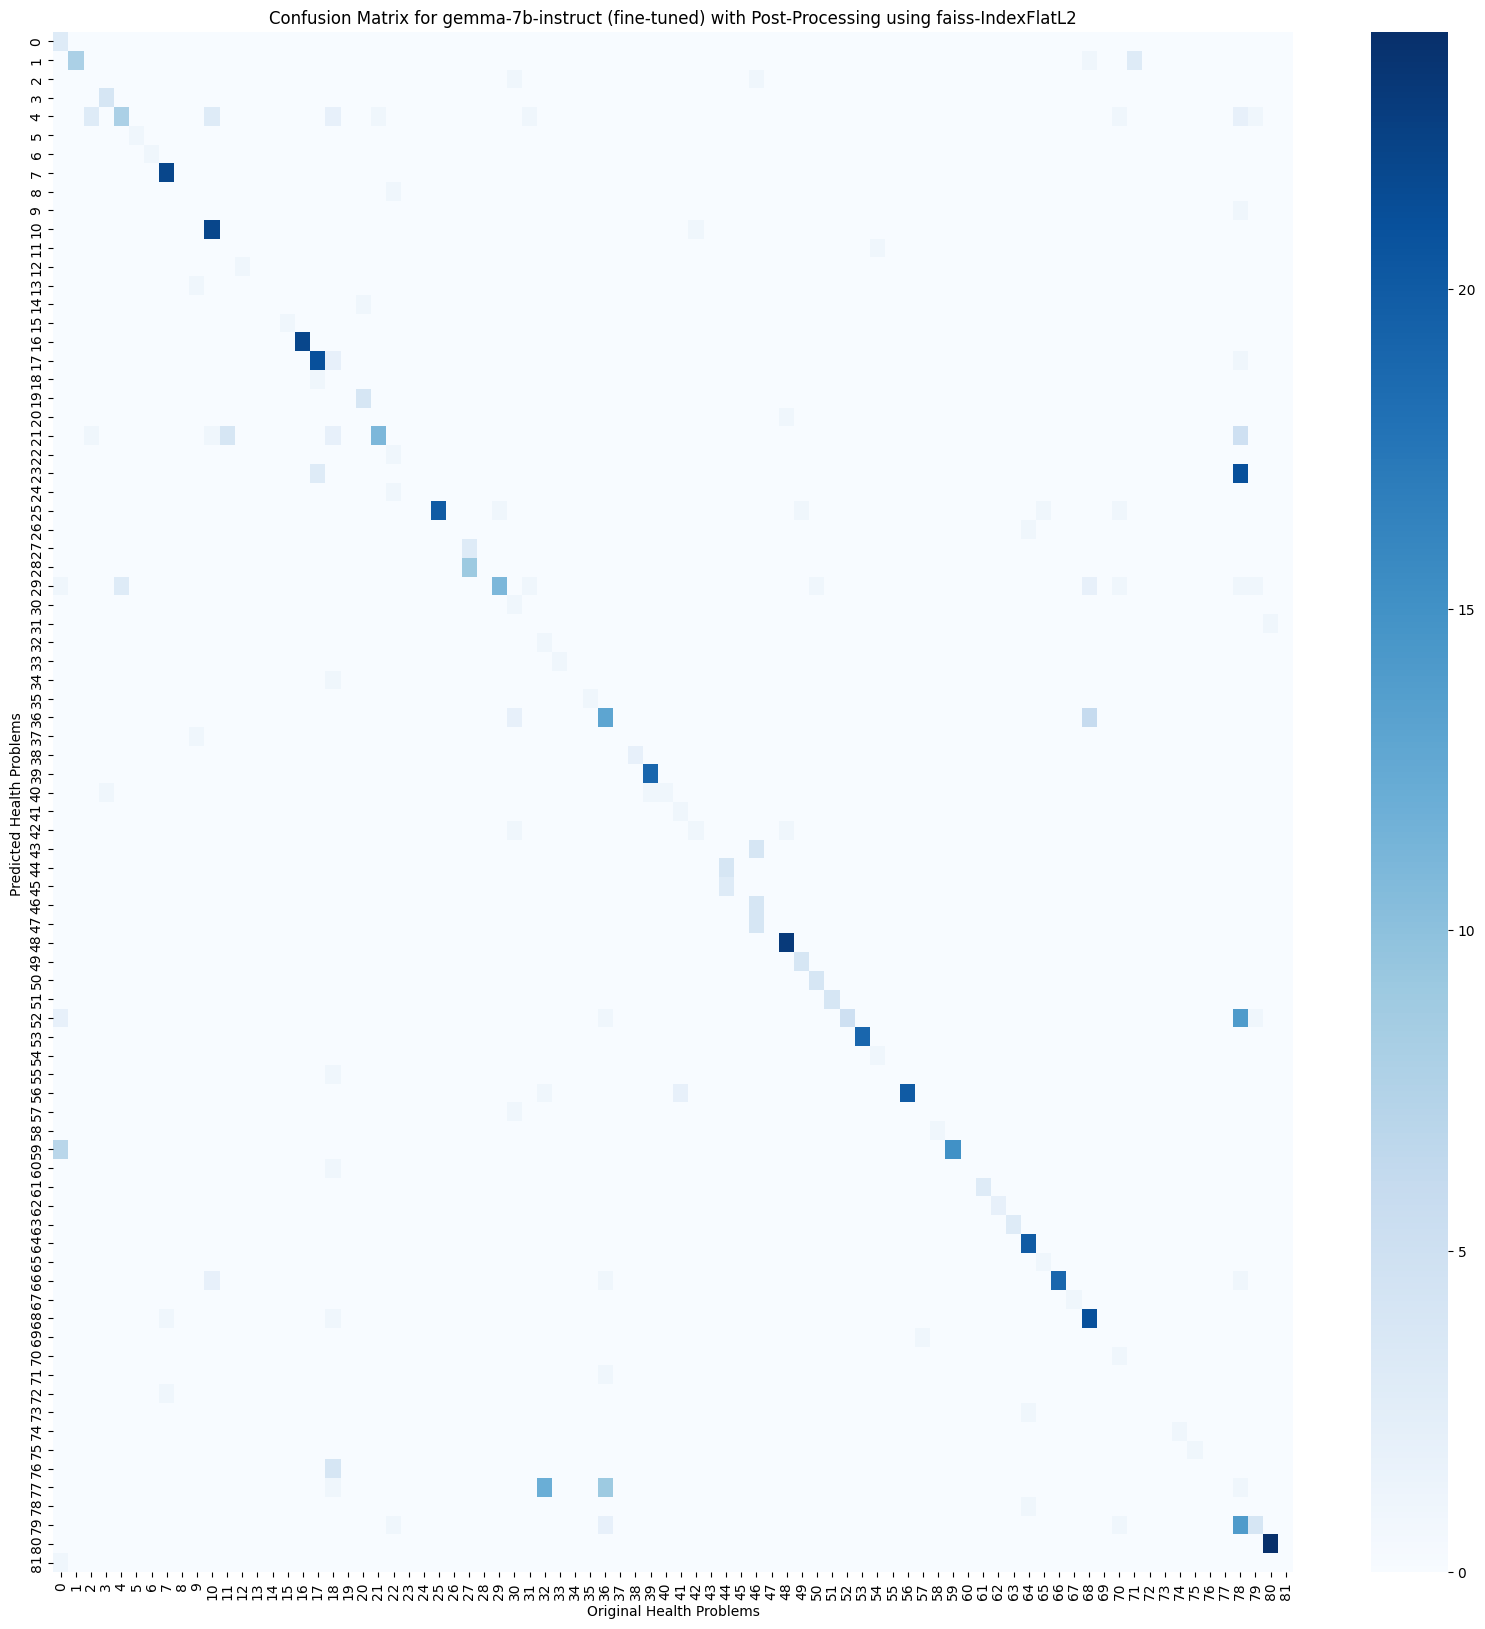

'success'

In [12]:
t2t_evaluate(model_name='Gemma-7B-Instruct'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-gemma-7b-instruct-fine-tune/results/predictions-gemma-7b-instruct-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  mistral-7b-instruct-v0.2
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.982

Classification Metrics:

Accuracy: 0.223
Precision: 0.367
Recall: 0.223
F1 Score: 0.226

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.245
ROUGE-2: 0.128
ROUGE-L: 0.244
ROUGE-Lsum: 0.244

Average BERT Precision: 0.848
Average BERT Recall: 0.867
Average BERT F1 Score: 0.857


-------------------------------------------------------------------------------


model-name :  mistral-7b-instruct-v0.2
model-type :  pretrained

valid-instruction-rating :  0.982

classification-metrics:

accuracy: 0.223
precision: 0.367
recall: 0.223
f1-score: 0.226

text-to-text-metrics:

rouge-scores:
rouge-1: 0.245
rouge-2: 0.128
rouge-L: 0.244
rouge-lsum: 0.244

bert-precision: 0.848
bert-recall: 0.867
bert-f1-score: 0.857

Updated llms_data dictionary:


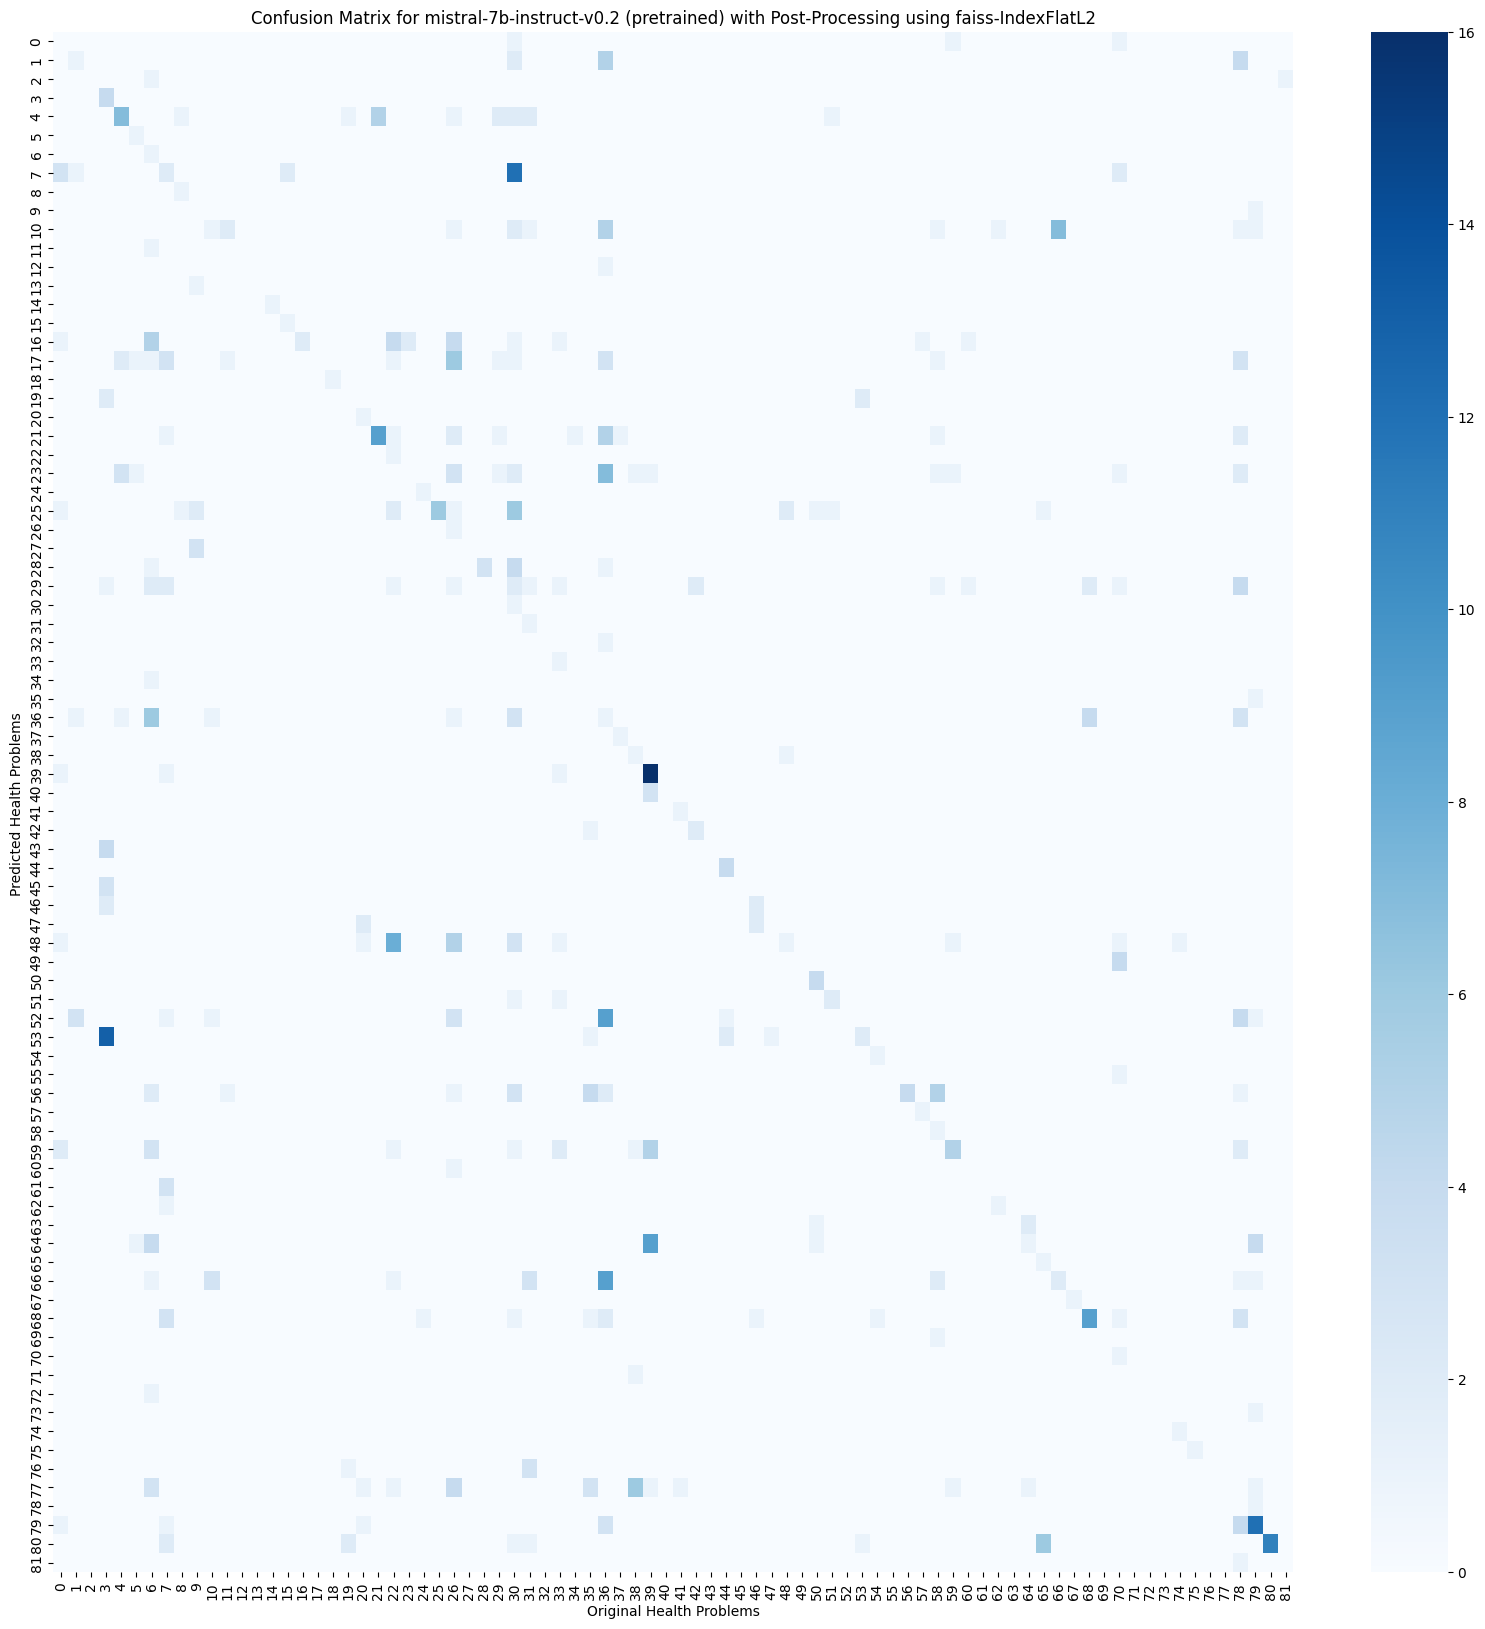

'success'

In [13]:
t2t_evaluate(model_name='Mistral-7B-Instruct-V0.2'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-mistral-7b-it-v2-pretrained/results/predictions-mistral-7b-instruct-v0.2-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  mistral-7b-instruct-v0.2
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.437

Classification Metrics:

Accuracy: 0.735
Precision: 0.787
Recall: 0.735
F1 Score: 0.737

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.756
ROUGE-2: 0.356
ROUGE-L: 0.756
ROUGE-Lsum: 0.756

Average BERT Precision: 0.962
Average BERT Recall: 0.958
Average BERT F1 Score: 0.959


-------------------------------------------------------------------------------


model-name :  mistral-7b-instruct-v0.2
model-type :  fine-tuned

valid-instruction-rating :  0.437

classification-metrics:

accuracy: 0.735
precision: 0.787
recall: 0.735
f1-score: 0.737

text-to-text-metrics:

rouge-scores:
rouge-1: 0.756
rouge-2: 0.356
rouge-L: 0.756
rouge-lsum: 0.756

bert-precision: 0.962
bert-recall: 0.958
bert-f1-score: 0.959

Updated llms_data dictionary:


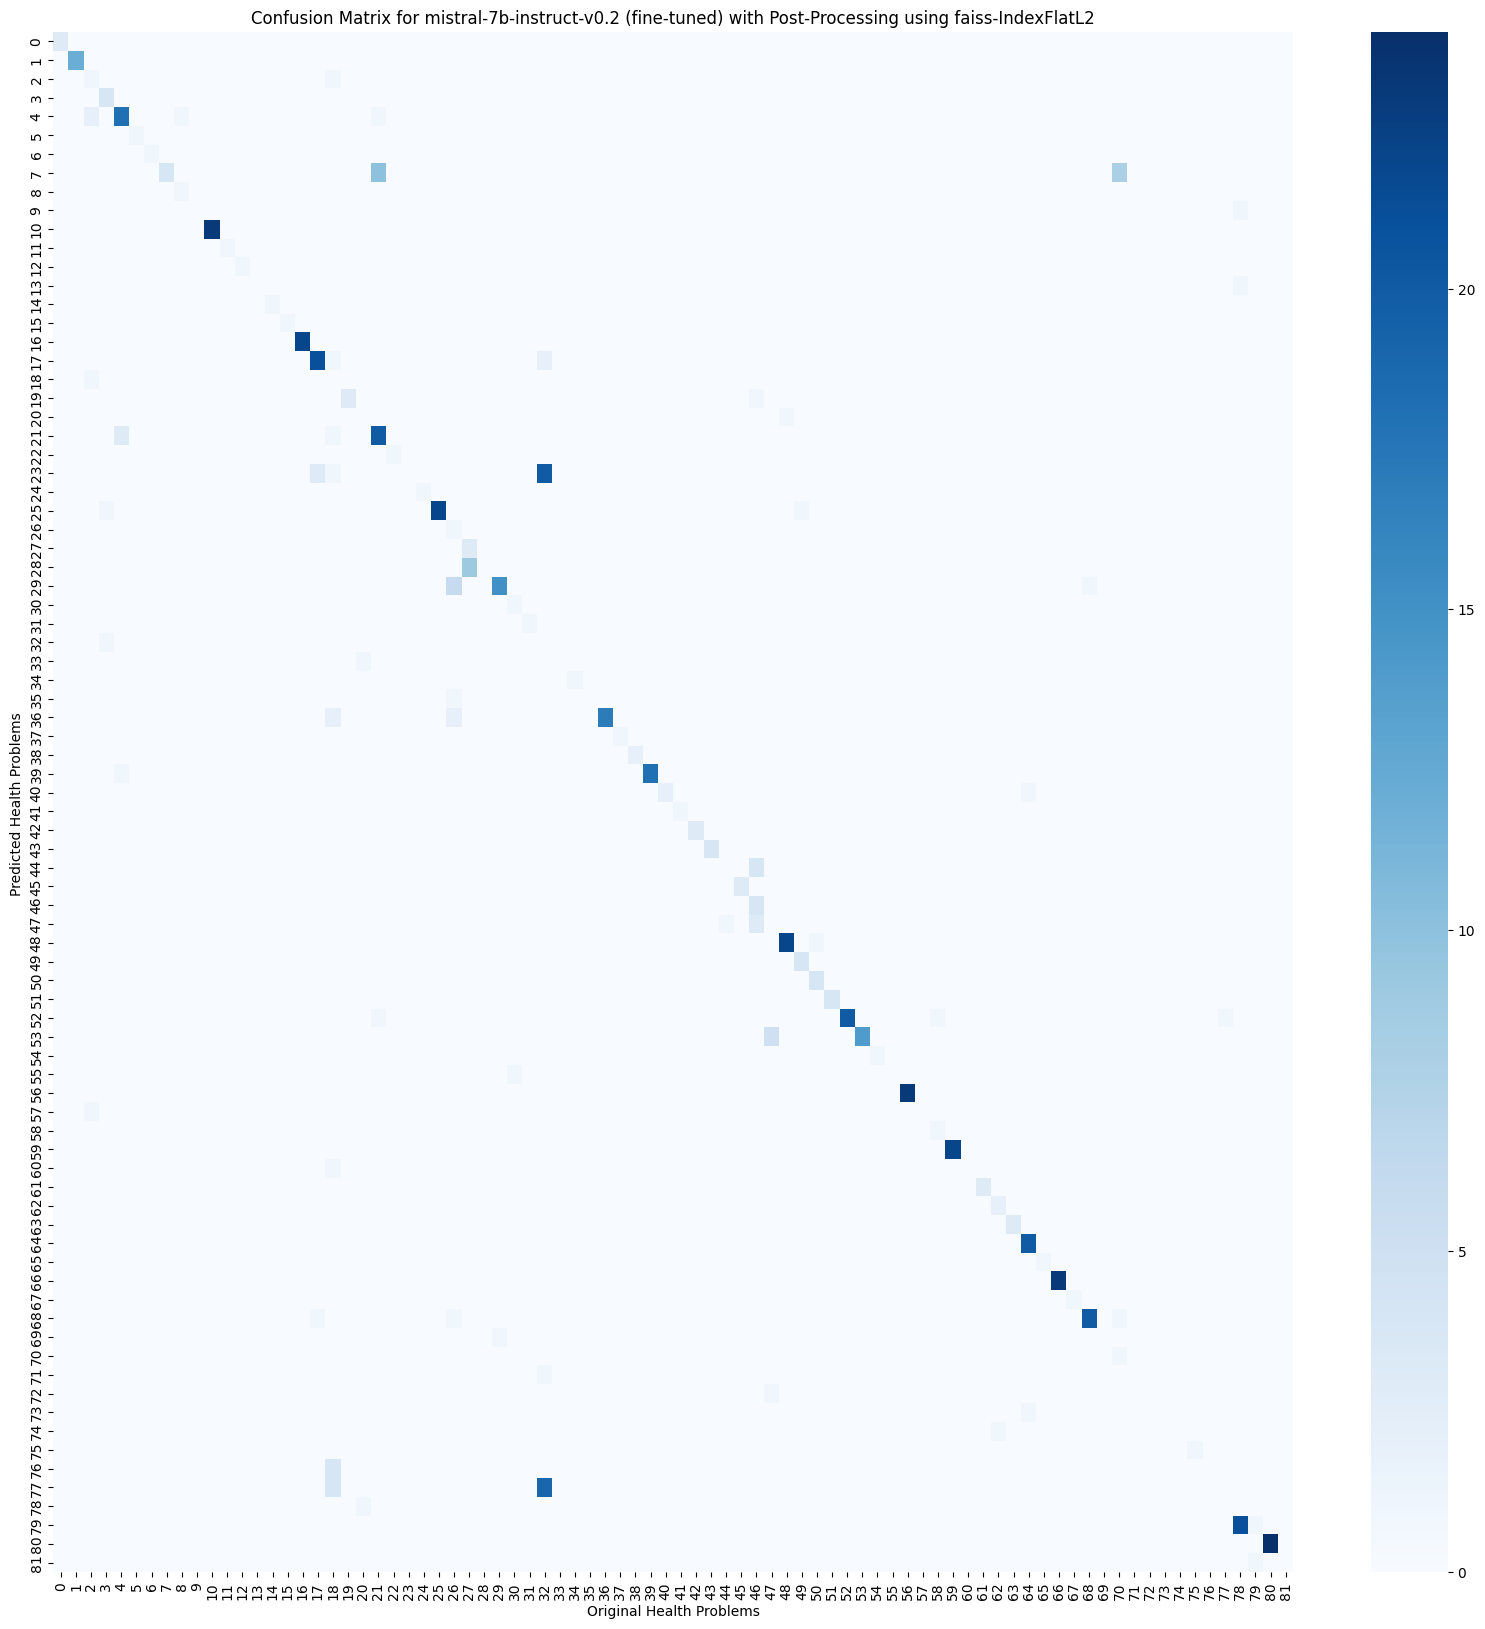

'success'

In [14]:
t2t_evaluate(model_name='Mistral-7B-Instruct-V0.2'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-mistral-7b-it-v2-fine-tuned/results/predictions-mistral-7b-instruct-v0.2-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  phi-3-medium-4k-instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.416

Classification Metrics:

Accuracy: 0.272
Precision: 0.404
Recall: 0.272
F1 Score: 0.262

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.312
ROUGE-2: 0.095
ROUGE-L: 0.310
ROUGE-Lsum: 0.310

Average BERT Precision: 0.869
Average BERT Recall: 0.875
Average BERT F1 Score: 0.871


-------------------------------------------------------------------------------


model-name :  phi-3-medium-4k-instruct
model-type :  pretrained

valid-instruction-rating :  0.416

classification-metrics:

accuracy: 0.272
precision: 0.404
recall: 0.272
f1-score: 0.262

text-to-text-metrics:

rouge-scores:
rouge-1: 0.312
rouge-2: 0.095
rouge-L: 0.310
rouge-lsum: 0.310

bert-precision: 0.869
bert-recall: 0.875
bert-f1-score: 0.871

Updated llms_data dictionary:


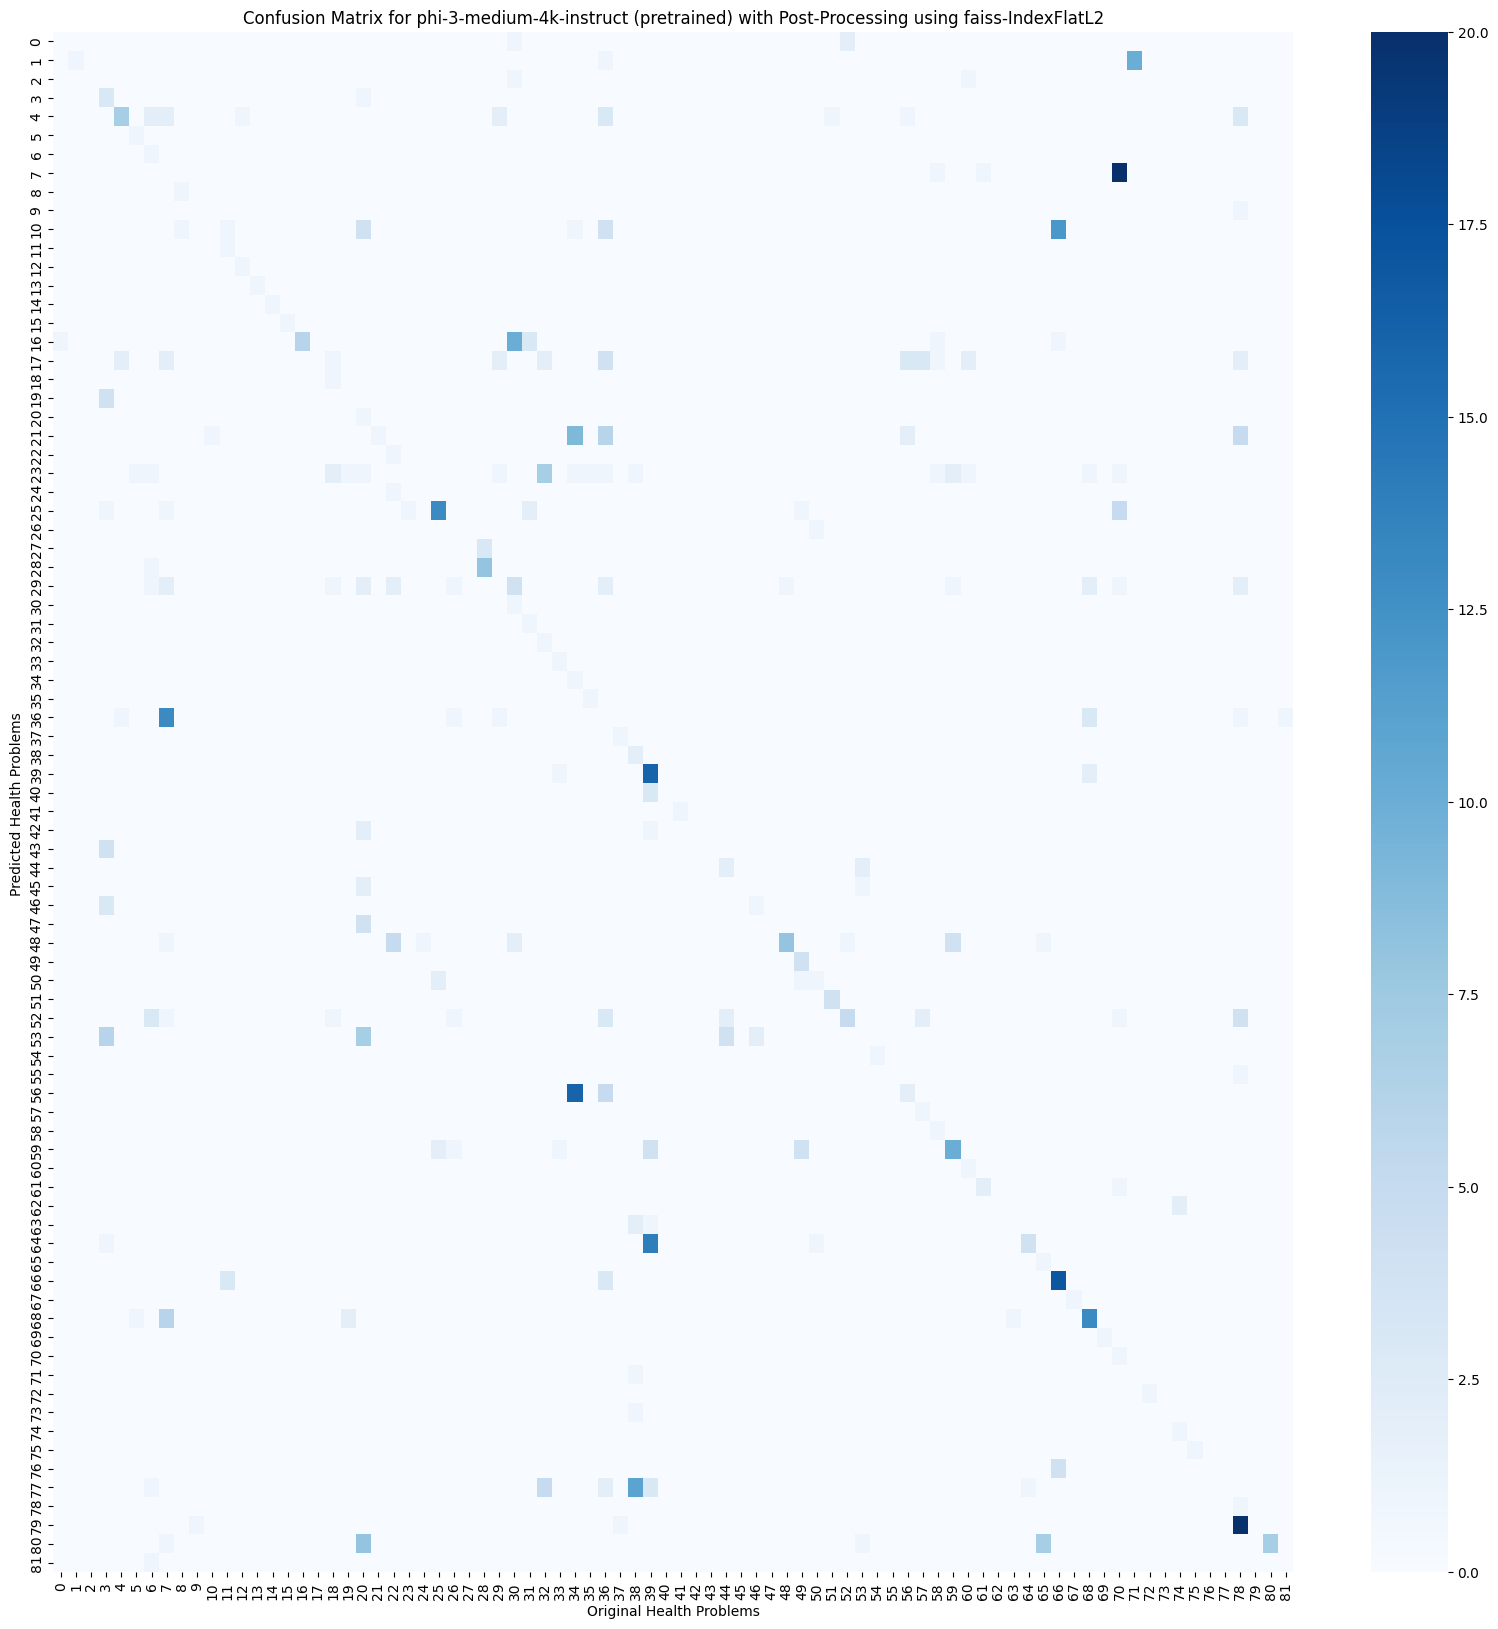

'success'

In [15]:
t2t_evaluate(model_name='Phi-3-Medium-4K-Instruct'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-phi-3-med-4k-it-pretrain/results/predictions-Phi-3-medium-4k-instruct-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  phi-3-medium-4k-instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.968

Classification Metrics:

Accuracy: 0.673
Precision: 0.783
Recall: 0.673
F1 Score: 0.682

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.688
ROUGE-2: 0.350
ROUGE-L: 0.685
ROUGE-Lsum: 0.688

Average BERT Precision: 0.946
Average BERT Recall: 0.947
Average BERT F1 Score: 0.946


-------------------------------------------------------------------------------


model-name :  phi-3-medium-4k-instruct
model-type :  fine-tuned

valid-instruction-rating :  0.968

classification-metrics:

accuracy: 0.673
precision: 0.783
recall: 0.673
f1-score: 0.682

text-to-text-metrics:

rouge-scores:
rouge-1: 0.688
rouge-2: 0.350
rouge-L: 0.685
rouge-lsum: 0.688

bert-precision: 0.946
bert-recall: 0.947
bert-f1-score: 0.946

Updated llms_data dictionary:


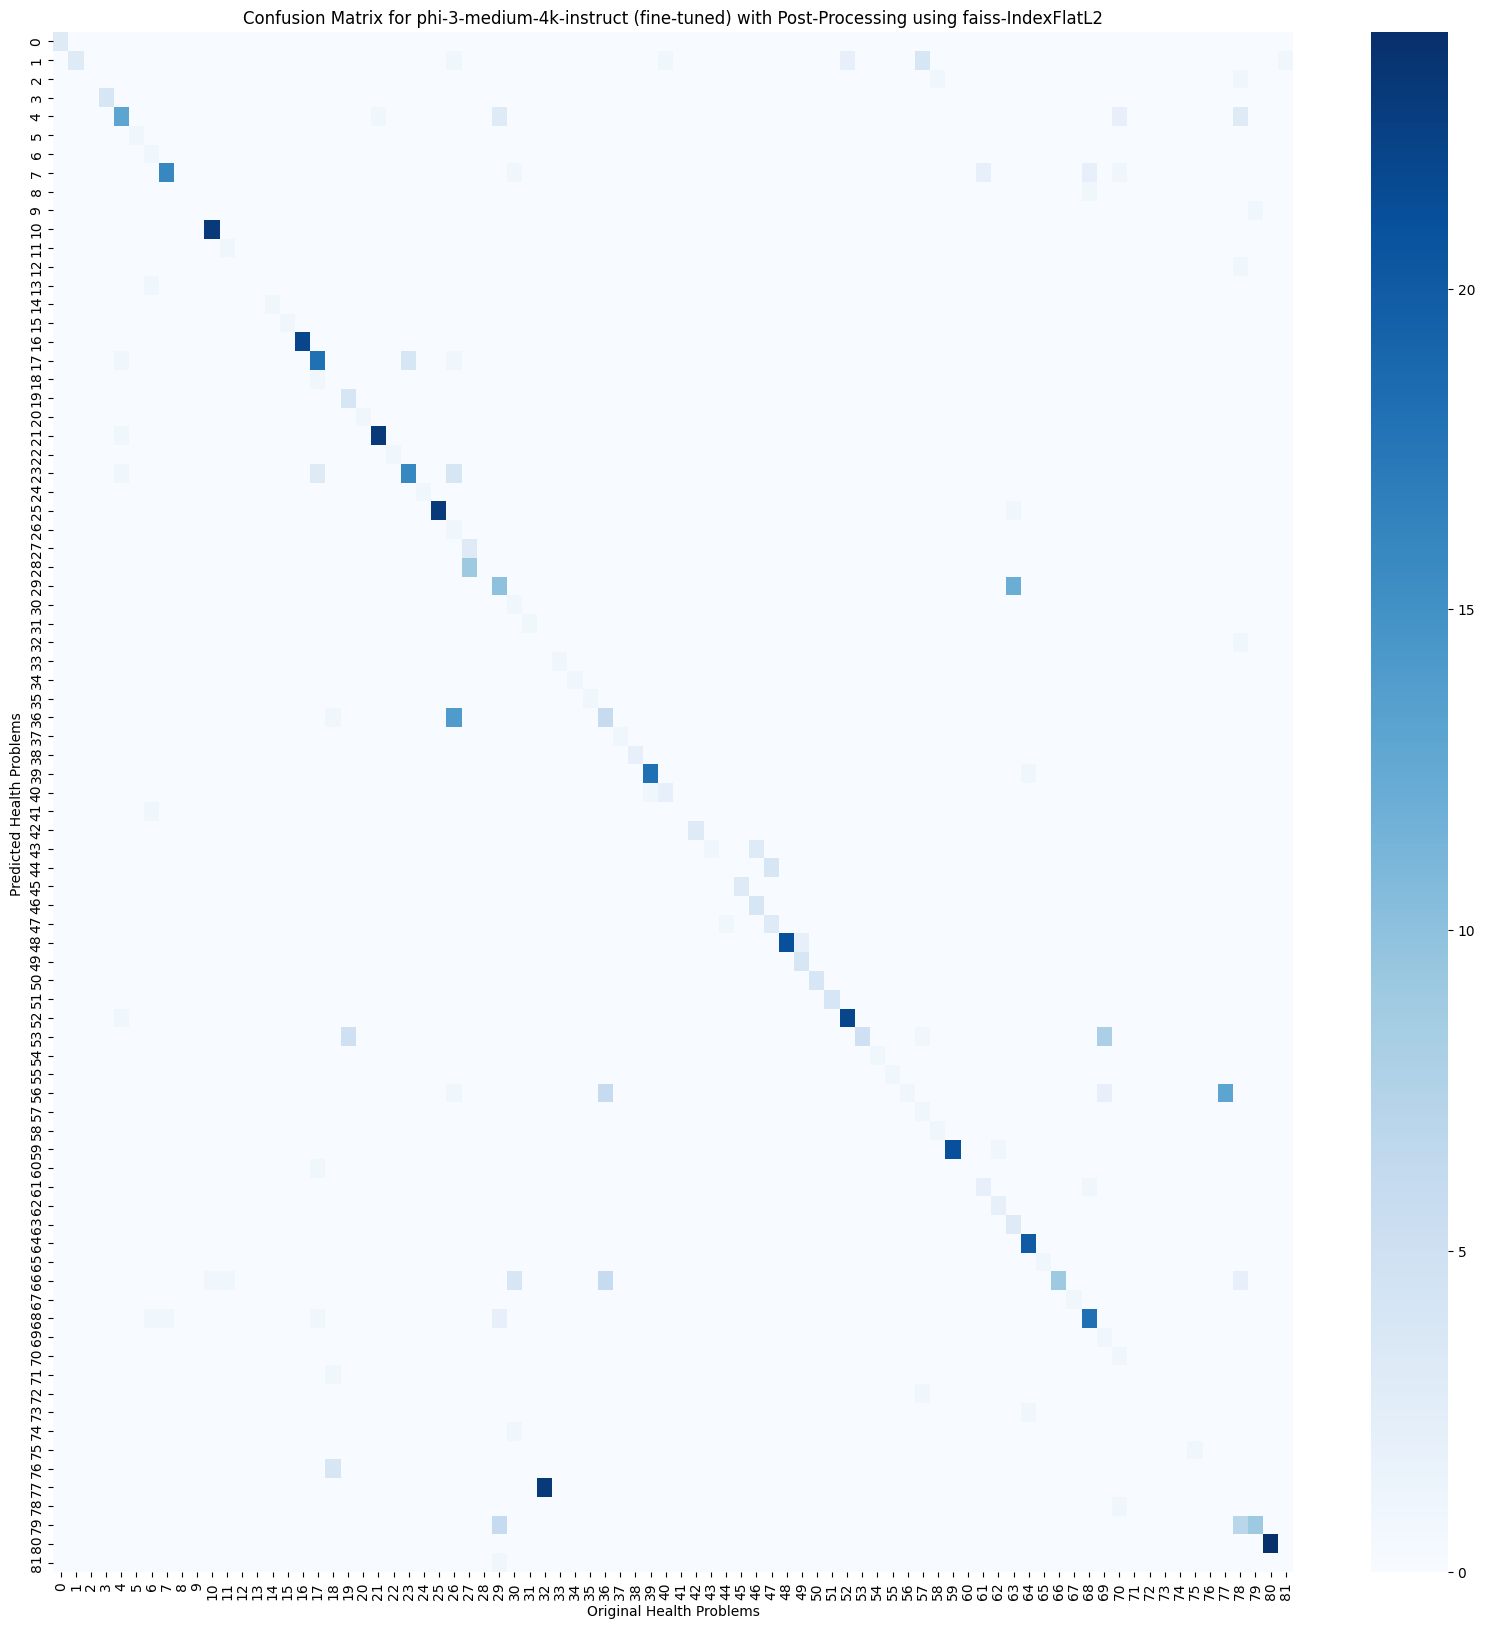

'success'

In [16]:
t2t_evaluate(model_name='Phi-3-Medium-4K-Instruct'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-phi-3-med-4k-it-fine-tuned/results/predictions-Phi-3-medium-4k-instruct-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  medical-llama3-8b
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.013

Classification Metrics:

Accuracy: 0.172
Precision: 0.378
Recall: 0.172
F1 Score: 0.191

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.182
ROUGE-2: 0.074
ROUGE-L: 0.183
ROUGE-Lsum: 0.182

Average BERT Precision: 0.832
Average BERT Recall: 0.859
Average BERT F1 Score: 0.845


-------------------------------------------------------------------------------


model-name :  medical-llama3-8b
model-type :  pretrained

valid-instruction-rating :  0.013

classification-metrics:

accuracy: 0.172
precision: 0.378
recall: 0.172
f1-score: 0.191

text-to-text-metrics:

rouge-scores:
rouge-1: 0.182
rouge-2: 0.074
rouge-L: 0.183
rouge-lsum: 0.182

bert-precision: 0.832
bert-recall: 0.859
bert-f1-score: 0.845

Updated llms_data dictionary:


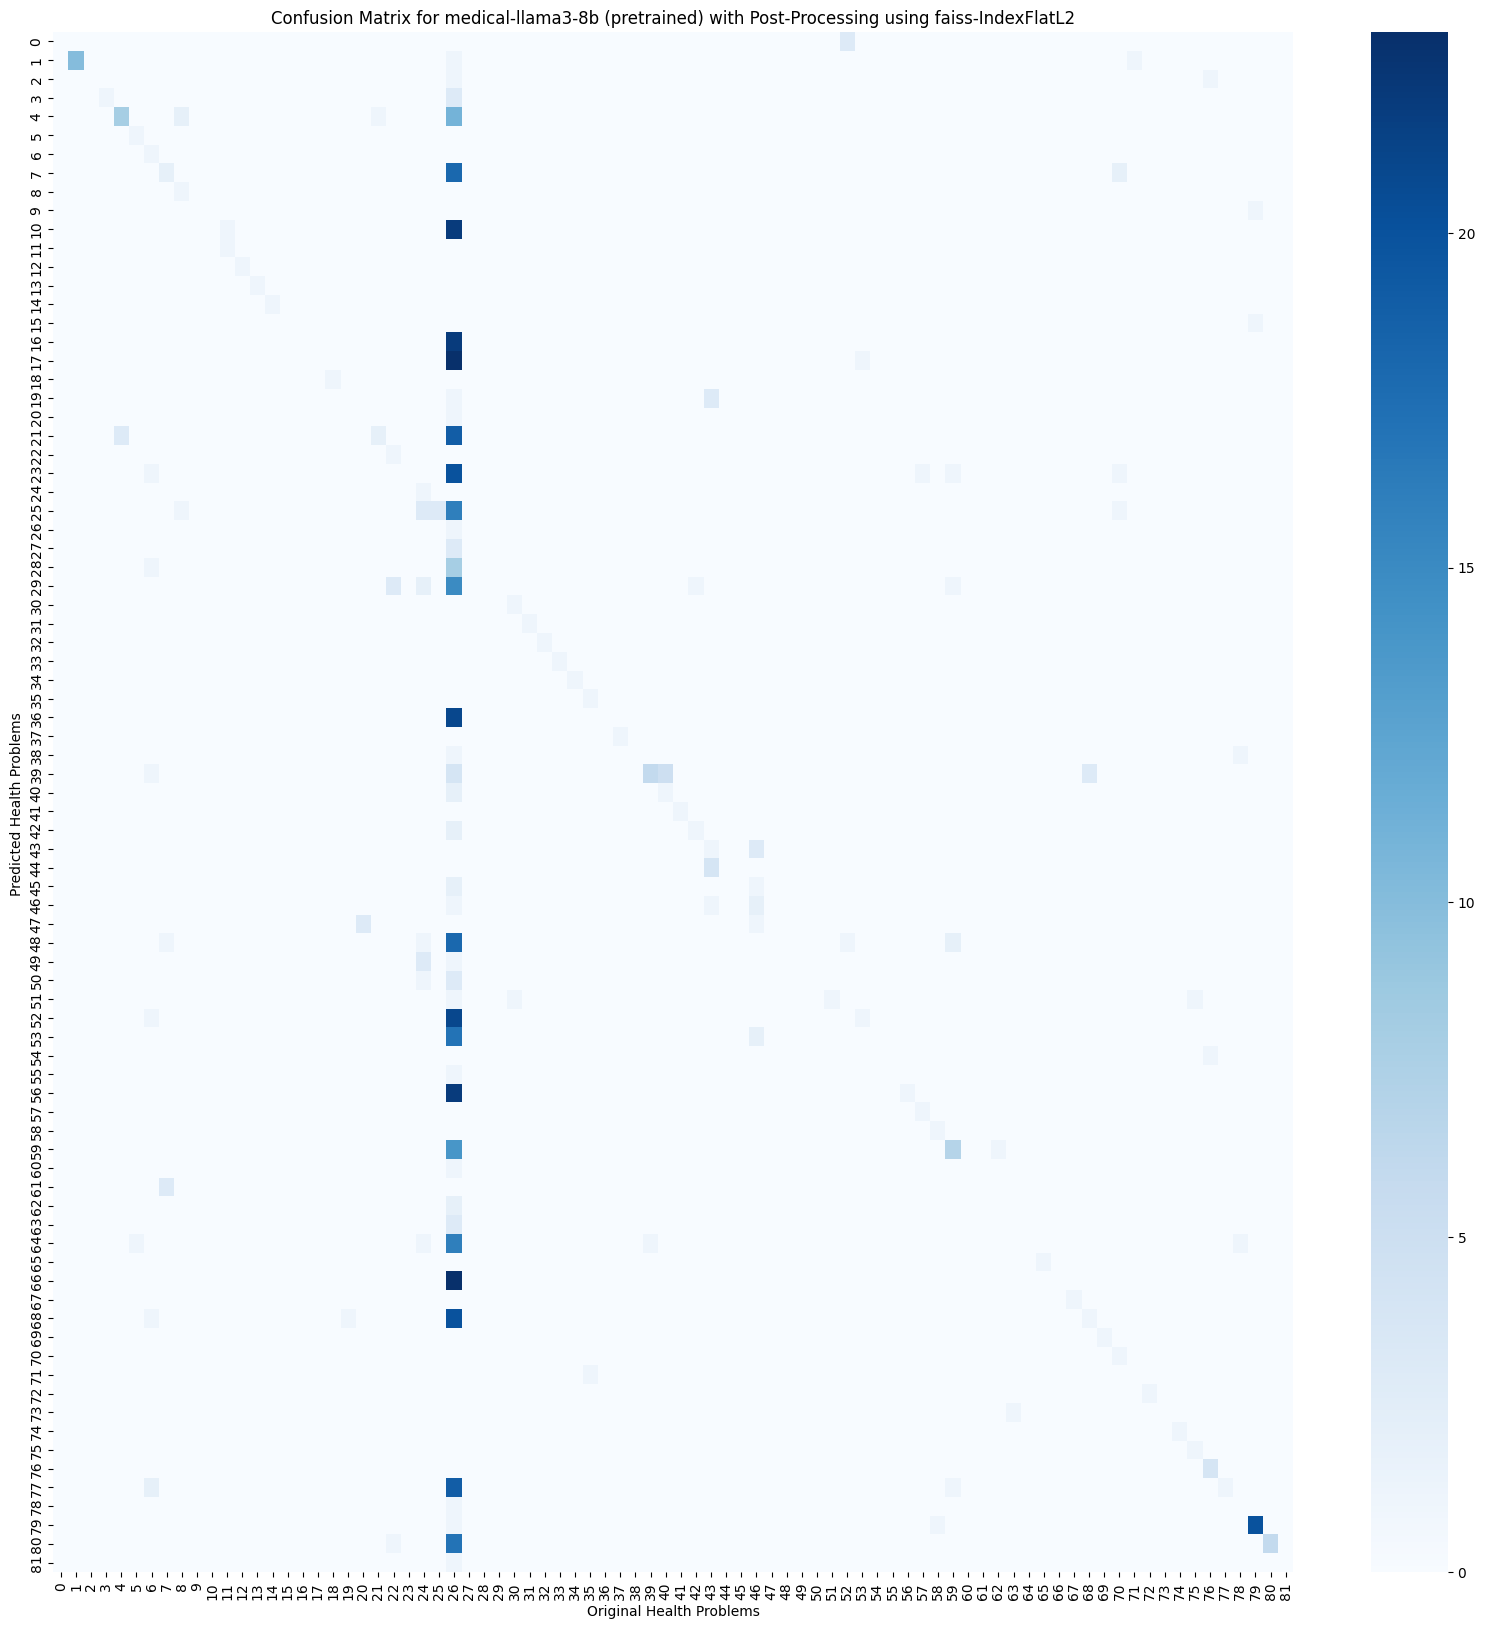

'success'

In [17]:
t2t_evaluate(model_name='Medical-LLaMA3-8B'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-medical-llama3-8b-pretrain/results/predictions-Medical-Llama3-8B-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  medical-llama3-8b
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.995

Classification Metrics:

Accuracy: 0.756
Precision: 0.863
Recall: 0.756
F1 Score: 0.766

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.795
ROUGE-2: 0.359
ROUGE-L: 0.794
ROUGE-Lsum: 0.794

Average BERT Precision: 0.957
Average BERT Recall: 0.967
Average BERT F1 Score: 0.961


-------------------------------------------------------------------------------


model-name :  medical-llama3-8b
model-type :  fine-tuned

valid-instruction-rating :  0.995

classification-metrics:

accuracy: 0.756
precision: 0.863
recall: 0.756
f1-score: 0.766

text-to-text-metrics:

rouge-scores:
rouge-1: 0.795
rouge-2: 0.359
rouge-L: 0.794
rouge-lsum: 0.794

bert-precision: 0.957
bert-recall: 0.967
bert-f1-score: 0.961

Updated llms_data dictionary:


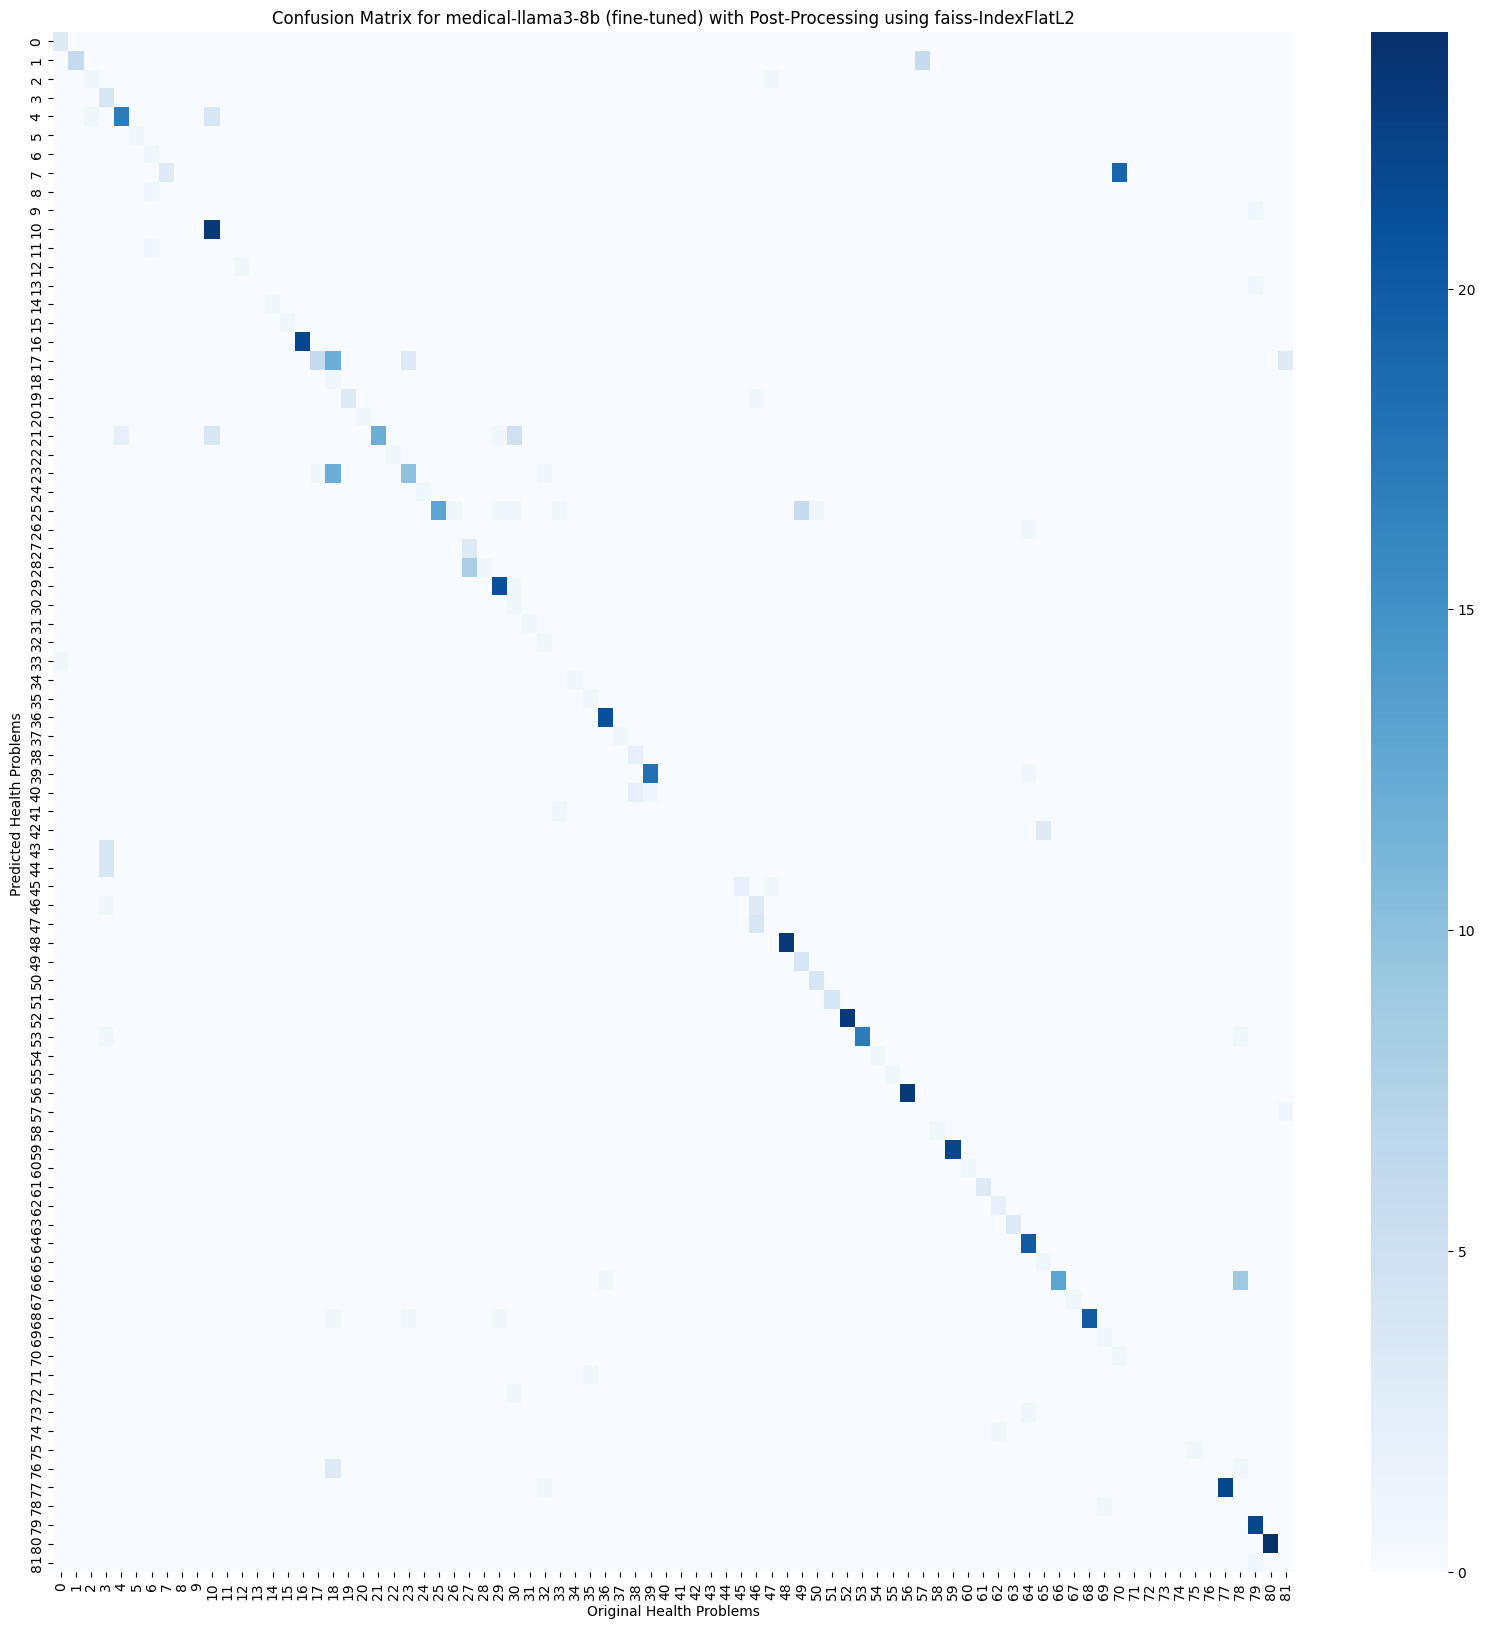

'success'

In [18]:
t2t_evaluate(model_name='Medical-LLaMA3-8B'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-medical-llama3-8b-fine-tune/results/predictions-Medical-Llama3-8B-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  LLaMA-3-8B-Instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.751

Classification Metrics:

Accuracy: 0.267
Precision: 0.366
Recall: 0.267
F1 Score: 0.251

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.299
ROUGE-2: 0.120
ROUGE-L: 0.299
ROUGE-Lsum: 0.300

Average BERT Precision: 0.858
Average BERT Recall: 0.879
Average BERT F1 Score: 0.867


-------------------------------------------------------------------------------


model-name :  LLaMA-3-8B-Instruct
model-type :  pretrained

valid-instruction-rating :  0.751

classification-metrics:

accuracy: 0.267
precision: 0.366
recall: 0.267
f1-score: 0.251

text-to-text-metrics:

rouge-scores:
rouge-1: 0.299
rouge-2: 0.120
rouge-L: 0.299
rouge-lsum: 0.300

bert-precision: 0.858
bert-recall: 0.879
bert-f1-score: 0.867

Updated llms_data dictionary:


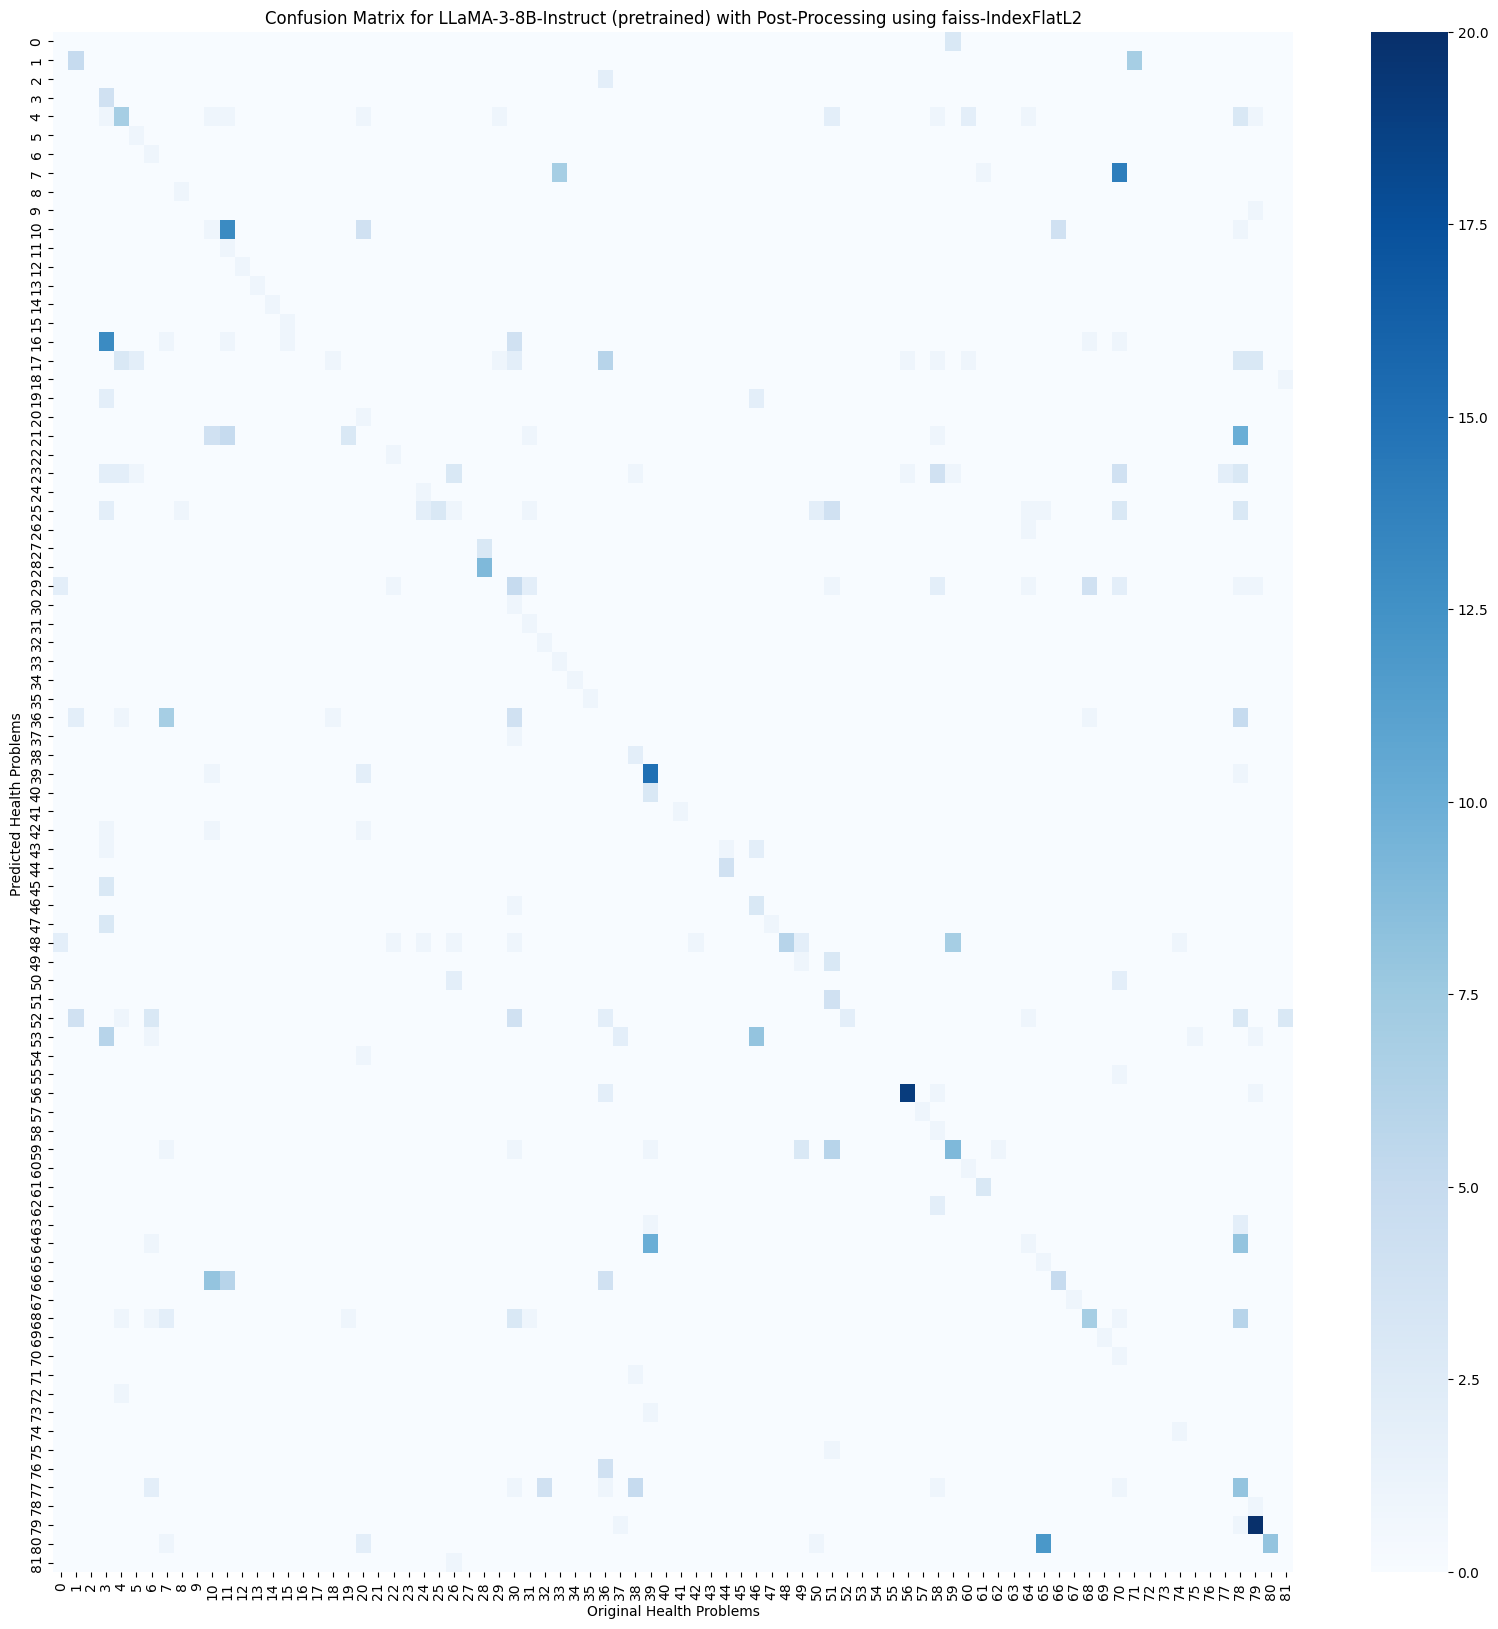

'success'

In [19]:
t2t_evaluate(model_name='LLaMA-3-8B-Instruct',model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-llama-3-8b-instruct-pretra/results/predictions-llama-3-8b-Instruct-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  LLaMA-3-8B-Instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  1.000

Classification Metrics:

Accuracy: 0.968
Precision: 0.957
Recall: 0.968
F1 Score: 0.961

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.969
ROUGE-2: 0.448
ROUGE-L: 0.968
ROUGE-Lsum: 0.969

Average BERT Precision: 0.994
Average BERT Recall: 0.994
Average BERT F1 Score: 0.994


-------------------------------------------------------------------------------


model-name :  LLaMA-3-8B-Instruct
model-type :  fine-tuned

valid-instruction-rating :  1.000

classification-metrics:

accuracy: 0.968
precision: 0.957
recall: 0.968
f1-score: 0.961

text-to-text-metrics:

rouge-scores:
rouge-1: 0.969
rouge-2: 0.448
rouge-L: 0.968
rouge-lsum: 0.969

bert-precision: 0.994
bert-recall: 0.994
bert-f1-score: 0.994

Updated llms_data dictionary:


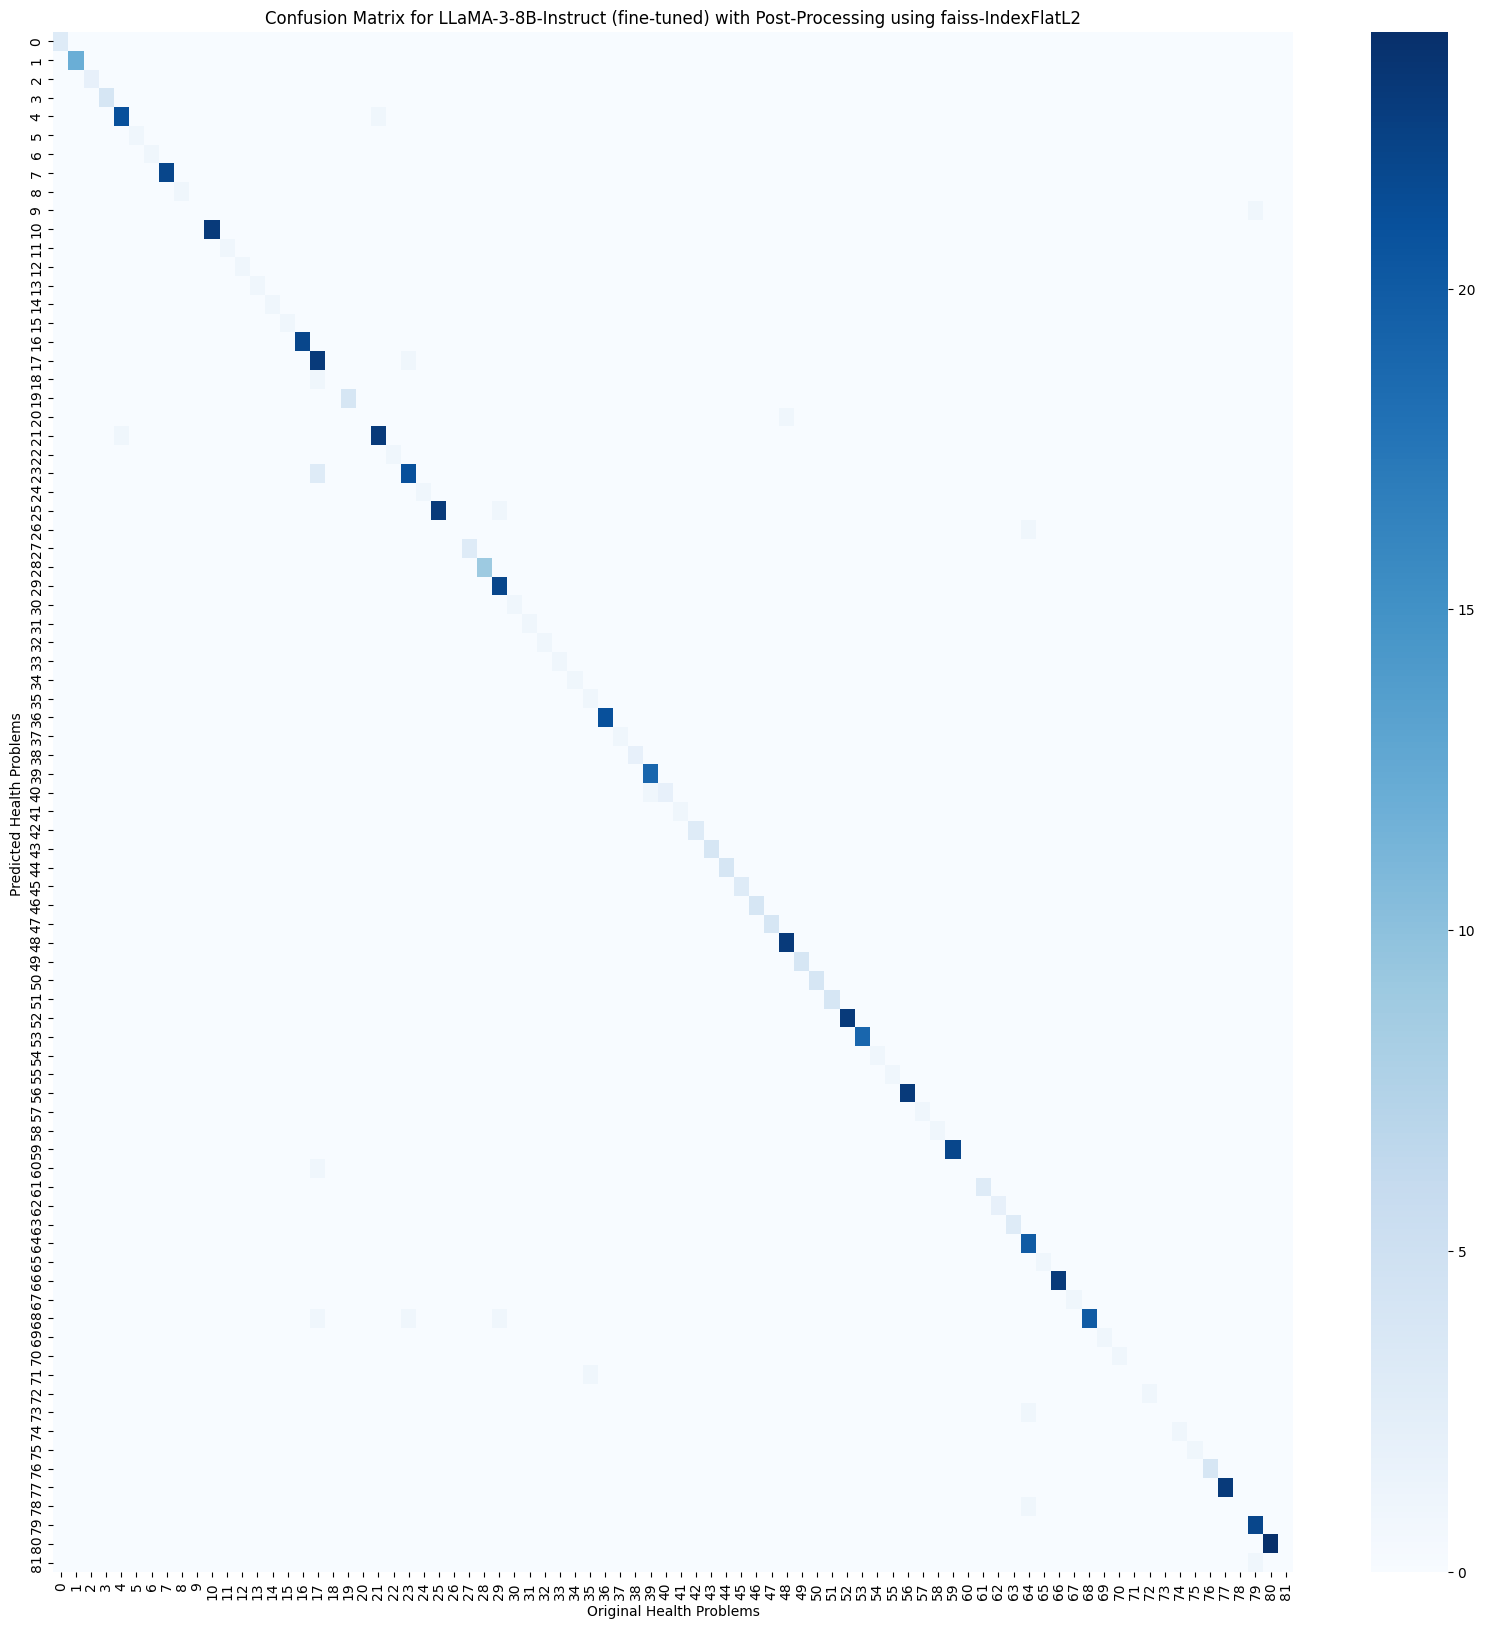

'success'

In [20]:
t2t_evaluate(model_name='LLaMA-3-8B-Instruct',model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-llama-3-8b-inst-fine-tuned/results/predictions-llama-3-8b-Instruct-fine-tuned-output.csv')

In [21]:
# llm_model_data = {}

In [22]:
# llm_model_data["qwen2-7b-instruct"]= {
#     "pretrained": {
#         "valid-instruction-rating": 0.997,
#         "classification-metrics": {
#             "accuracy": 0.050,
#             "precision": 0.253,
#             "recall": 0.050,
#             "f1-score": 0.064
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.200,
#                 "rouge-2": 0.073,
#                 "rouge-L": 0.200,
#                 "rouge-lsum": 0.200
#             },
#             "bert-precision": 0.828,
#             "bert-recall": 0.858,
#             "bert-f1-score": 0.842
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.998,
#         "classification-metrics": {
#             "accuracy": 0.738,
#             "precision": 0.931,
#             "recall": 0.738,
#             "f1-score": 0.778
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.871,
#                 "rouge-2": 0.411,
#                 "rouge-L": 0.871,
#                 "rouge-lsum": 0.871
#             },
#             "bert-precision": 0.962,
#             "bert-recall": 0.978,
#             "bert-f1-score": 0.970
#         }
#     }
# }

In [23]:
# llm_model_data["gemma-7b-instruct"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.134,
#         "classification-metrics": {
#             "accuracy": 0.057,
#             "precision": 0.191,
#             "recall": 0.057,
#             "f1-score": 0.074
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.162,
#                 "rouge-2": 0.066,
#                 "rouge-L": 0.162,
#                 "rouge-lsum": 0.162
#             },
#             "bert-precision": 0.838,
#             "bert-recall": 0.842,
#             "bert-f1-score": 0.840
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.974,
#         "classification-metrics": {
#             "accuracy": 0.078,
#             "precision": 0.288,
#             "recall": 0.078,
#             "f1-score": 0.101
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.461,
#                 "rouge-2": 0.201,
#                 "rouge-L": 0.461,
#                 "rouge-lsum": 0.461
#             },
#             "bert-precision": 0.860,
#             "bert-recall": 0.933,
#             "bert-f1-score": 0.895
#         }
#     }
# }


In [24]:
# llm_model_data["mistral-7b-instruct-v0.2"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.982,
#         "classification-metrics": {
#             "accuracy": 0.057,
#             "precision": 0.192,
#             "recall": 0.057,
#             "f1-score": 0.065
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.155,
#                 "rouge-2": 0.064,
#                 "rouge-L": 0.155,
#                 "rouge-lsum": 0.154
#             },
#             "bert-precision": 0.835,
#             "bert-recall": 0.842,
#             "bert-f1-score": 0.838
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.437,
#         "classification-metrics": {
#             "accuracy": 0.383,
#             "precision": 0.482,
#             "recall": 0.383,
#             "f1-score": 0.414
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.715,
#                 "rouge-2": 0.364,
#                 "rouge-L": 0.714,
#                 "rouge-lsum": 0.715
#             },
#             "bert-precision": 0.921,
#             "bert-recall": 0.963,
#             "bert-f1-score": 0.941
#         }
#     }
# }


In [25]:
# llm_model_data["phi-3-medium-4k-instruct"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.416,
#         "classification-metrics": {
#             "accuracy": 0.154,
#             "precision": 0.446,
#             "recall": 0.154,
#             "f1-score": 0.179
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.298,
#                 "rouge-2": 0.079,
#                 "rouge-L": 0.298,
#                 "rouge-lsum": 0.298
#             },
#             "bert-precision": 0.853,
#             "bert-recall": 0.872,
#             "bert-f1-score": 0.862
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.968,
#         "classification-metrics": {
#             "accuracy": 0.015,
#             "precision": 0.081,
#             "recall": 0.015,
#             "f1-score": 0.020
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.482,
#                 "rouge-2": 0.222,
#                 "rouge-L": 0.482,
#                 "rouge-lsum": 0.482
#             },
#             "bert-precision": 0.859,
#             "bert-recall": 0.942,
#             "bert-f1-score": 0.898
#         }
#     }
# }


In [26]:
# llm_model_data["medical-llama3-8b"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.013,
#         "classification-metrics": {
#             "accuracy": 0.139,
#             "precision": 0.354,
#             "recall": 0.139,
#             "f1-score": 0.157
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.174,
#                 "rouge-2": 0.069,
#                 "rouge-L": 0.174,
#                 "rouge-lsum": 0.174
#             },
#             "bert-precision": 0.855,
#             "bert-recall": 0.822,
#             "bert-f1-score": 0.838
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.995,
#         "classification-metrics": {
#             "accuracy": 0.057,
#             "precision": 0.204,
#             "recall": 0.057,
#             "f1-score": 0.069
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.488,
#                 "rouge-2": 0.223,
#                 "rouge-L": 0.487,
#                 "rouge-lsum": 0.487
#             },
#             "bert-precision": 0.862,
#             "bert-recall": 0.943,
#             "bert-f1-score": 0.900
#         }
#     }
# }


In [27]:
# llm_model_data["llama-3-8b-instruct"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.751,
#         "classification-metrics": {
#             "accuracy": 0.107,
#             "precision": 0.237,
#             "recall": 0.107,
#             "f1-score": 0.123
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.238,
#                 "rouge-2": 0.071,
#                 "rouge-L": 0.237,
#                 "rouge-lsum": 0.238
#             },
#             "bert-precision": 0.839,
#             "bert-recall": 0.869,
#             "bert-f1-score": 0.853
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 1.000,
#         "classification-metrics": {
#             "accuracy": 0.961,
#             "precision": 0.955,
#             "recall": 0.961,
#             "f1-score": 0.957
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.966,
#                 "rouge-2": 0.448,
#                 "rouge-L": 0.966,
#                 "rouge-lsum": 0.966
#             },
#             "bert-precision": 0.994,
#             "bert-recall": 0.994,
#             "bert-f1-score": 0.994
#         }
#     }
# }


In [28]:
import os
import json

# Define the directory path
directory = f'/kaggle/working/evaluation/{index_type}/results'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, 'medical-chatbot-models-evaluation.json')

# Assuming llms_data contains the dictionary you want to save
with open(file_path, 'w') as json_file:
    json.dump(llms_data, json_file, indent=4)


In [29]:
import csv
import json
import os

directory = f'/kaggle/working/evaluation/{index_type}/results'
file_path = os.path.join(directory, 'medical-chatbot-models-evaluation.csv')

# Create a CSV file and write header
with open(file_path, mode='w', newline='') as file:
    fieldnames = ['model-name', 'type', 'valid-instruction-following', 'accuracy', 'precision', 'recall', 'f1-score', 
                  'rouge-1', 'rouge-2', 'rouge-l', 'rouge-lsum', 'bert-precision', 'bert-recall', 'bert-f1-score']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    
    writer.writeheader()
    
    for model_name, model_types in llms_data.items():
        for model_type, metrics in model_types.items():
            writer.writerow({
                'model-name': model_name,
                'type': model_type,
                'valid-instruction-following': metrics['valid-instruction-rating'],
                'accuracy': metrics['classification-metrics']['accuracy'],
                'precision': metrics['classification-metrics']['precision'],
                'recall': metrics['classification-metrics']['recall'],
                'f1-score': metrics['classification-metrics']['f1-score'],
                'rouge-1': metrics['text-to-text-metrics']['rouge-scores']['rouge-1'],
                'rouge-2': metrics['text-to-text-metrics']['rouge-scores']['rouge-2'],
                'rouge-l': metrics['text-to-text-metrics']['rouge-scores']['rouge-L'],
                'rouge-lsum': metrics['text-to-text-metrics']['rouge-scores']['rouge-lsum'],
                'bert-precision': metrics['text-to-text-metrics']['bert-precision'],
                'bert-recall': metrics['text-to-text-metrics']['bert-recall'],
                'bert-f1-score': metrics['text-to-text-metrics']['bert-f1-score']
            })

print("CSV file created successfully at:", file_path)

CSV file created successfully at: /kaggle/working/evaluation/faiss-IndexFlatL2/results/medical-chatbot-models-evaluation.csv
